In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Create Spark Session

spark = SparkSession.builder.appName('basics').getOrCreate()

sqlContext.setConf("spark.sql.parquet.compression.codec", "snappy")

In [3]:
# Creating schema for table1
from pyspark.sql.types import (StructField,StructType,StringType,IntegerType,FloatType,LongType)

data_schema = [ StructField('jobTitle',StringType(),True),
                StructField('numberOfPositions',IntegerType(),True),
                StructField('payRate',StringType(),True),
                StructField('postDate',StringType(),True),
                StructField('siteName',StringType(),True),
                StructField('skills',StringType(),True),
                StructField('uniqueId',StringType(),True)
             
]

final_struc = StructType(fields=data_schema)

In [4]:
# Reading table 1 from MySql Database
table1 = spark.read.format("jdbc").option("url", "jdbc:mysql://localhost/naukridatabase").option("driver","com.mysql.jdbc.Driver").option("dbtable", "otherdescription").option("user", "root").option("password", "").option("schema",final_struc).option("partition",4).load()

In [37]:
# persisting table in memory for performing furture operations
table1 = table1.persist()

In [6]:
table1.show(2)

+--------------------+-----------------+--------------------+--------------------+--------+---------+--------------------+
|            jobTitle|numberOfPositions|             payRate|            postDate|siteName|   skills|            uniqueId|
+--------------------+-----------------+--------------------+--------------------+--------+---------+--------------------+
|Advertising Execu...|                0|Not Disclosed by ...|2015-12-29 02:24:...|        |Marketing|0000ac8099283dd54...|
|Required MBA Fres...|               20|1,25,000 - 2,00,0...|2016-05-03 11:35:...|        |         |0001932463014f38e...|
+--------------------+-----------------+--------------------+--------------------+--------+---------+--------------------+
only showing top 2 rows



In [21]:
# We need to convert the blank values to null to fill them after that
table1 = table1.withColumn('jobTitle', when(col('jobTitle') == '', None).otherwise(col('jobTitle')))
table1 = table1.withColumn('numberOfPositions', when(col('numberOfPositions') == '', None).otherwise(col('numberOfPositions')))
table1 = table1.withColumn('payRate', when(col('payRate') == '', None).otherwise(col('payRate')))
table1 = table1.withColumn('postDate', when(col('postDate') == '', None).otherwise(col('postDate')))
table1 = table1.withColumn('siteName', when(col('siteName') == '', None).otherwise(col('siteName')))
table1 = table1.withColumn('skills', when(col('skills') == '', None).otherwise(col('skills')))

In [22]:
# checking if any Null/Nan still exists
table1.select([count(when(isnull(c), c)).alias(c) for c in table1.columns]).show()

+--------+-----------------+-------+--------+--------+------+---------+
|jobTitle|numberOfPositions|payRate|postDate|siteName|skills|uniqueId2|
+--------+-----------------+-------+--------+--------+------+---------+
|       0|                0|     97|      24|   18012|   528|        0|
+--------+-----------------+-------+--------+--------+------+---------+



In [25]:
# Mysql has automatically converted integer column null to 0. But numberOfPositions can't be 0 replacing that with 1 
table1 = table1.replace(0,1,"numberOfPositions")

In [23]:
table1 = table1.withColumnRenamed('uniqueId','uniqueId2')

In [11]:

# --- Replacing value in rows(Can be done using when-then or replace)
#table1.replace(["M", "F"], ["0", "1"], "gender")

# --- Casting datatype( can be done using round().cast() or this way)
#user_gender.select("userId", user_gender.gender.cast("int"))

# -- Aggregation and changing name (can be done using alias or withColumnRenamed)
#user_NumofSongs = df_withchurn.filter(df_withchurn.page=="NextSong").dropDuplicates().groupby("userId").count()
#user_NumofSongs = user_NumofSongs.withColumnRenamed("count", "NumofSongs").sort('userId')

In [27]:
# replacing all the null values by 1 and unknown
table1 = table1.na.fill({'jobTitle':'unknown','numberOfPositions': 1,'payRate':'as per industry standards','postDate':'unknown','siteName': 'unknown','skills':'unknown'})
table1 = table1.filter(table1['postDate'] !='unknown')

In [39]:
table1.groupBy('siteName').count().show()

+--------------+-----+
|      siteName|count|
+--------------+-----+
|       unknown|17991|
|www.naukri.com| 3985|
+--------------+-----+



In [42]:
# replace siteName column value with www.naukri.com
table1 = table1.replace('unknown','www.naukri.com',"siteName")

In [43]:
# seeing the structure of table
table1.printSchema()

root
 |-- jobTitle: string (nullable = false)
 |-- numberOfPositions: integer (nullable = false)
 |-- payRate: string (nullable = false)
 |-- postDate: string (nullable = false)
 |-- siteName: string (nullable = false)
 |-- skills: string (nullable = false)
 |-- uniqueId2: string (nullable = true)



In [44]:
# checking if any Null/Nan still exists
table1.select([count(when(isnull(c), c)).alias(c) for c in table1.columns]).show()

+--------+-----------------+-------+--------+--------+------+---------+
|jobTitle|numberOfPositions|payRate|postDate|siteName|skills|uniqueId2|
+--------+-----------------+-------+--------+--------+------+---------+
|       0|                0|      0|       0|       0|     0|        0|
+--------+-----------------+-------+--------+--------+------+---------+



In [106]:
table1 = table1.dropDuplicates()

In [107]:
# final clearned and structured table 
table1.toPandas().head(5)

,jobTitle,numberOfPositions,payRate,postDate,siteName,skills,uniqueId2
0,Services Project Manager,1,Not Disclosed by Recruiter,2016-03-08 02:30:35 +0000,www.naukri.com,IT Software - Other,00c54a243f85a75a3c310840bf9c8bdb
1,TREASURY DEALER,1,Not Disclosed by Recruiter,2016-12-07 10:37:36 +0000,www.naukri.com,Financial Services,012977a7630d3ba29e2f902786135068
2,Senior ETL / BI Developer,1,Not Disclosed by Recruiter,2016-03-31 07:23:40 +0000,www.naukri.com,IT Software - Application Programming,04d969c7de5663e56a3ace0103588c70
3,Sr. Executive/Asst. manager - QC Metrology,1,Not Disclosed by Recruiter,2015-12-29 02:23:51 +0000,www.naukri.com,Production,04df3247d92f86e194e662e6db2cec5a
4,iOS Developer,1,Not Disclosed by Recruiter,2016-08-06 18:44:10 +0000,www.naukri.com,IT Software - Application Programming,05f4f37b6b2cb61ec199a00d25da5ea7


In [32]:
#storing table in compressed parquet format with snappy compression
table1.write.parquet("C:/jobPortalTables/table1/otherDescption/",partitionBy='skills',compression='snappy')

In [84]:
# Creating schema for table2
from pyspark.sql.types import (StructField,StructType,StringType,IntegerType,LongType,LongType)

data_schema2 = [ StructField('company',StringType(),True),
                StructField('education',StringType(),True),
                StructField('experience',StringType(),True),
                StructField('industry',StringType(),True),
                StructField('jobDescription',StringType(),True),
                StructField('jobId',LongType(),True),
                StructField('jobLocation',StringType(),True),
                StructField('uniqueId',StringType(),True)
             
]

final_struc2 = StructType(fields=data_schema)

In [91]:
# Reading table 2 from MySql Database
table2 = spark.read.format("jdbc").option("url", "jdbc:mysql://localhost/naukridatabase").option("driver","com.mysql.jdbc.Driver").option("dbtable", "jobdescription").option("user", "root").option("password", "").option("schema",final_struc2).option("partition",4).load()

In [92]:
# Persisting table in memory for performing furture operations
table2 = table2.persist()

In [97]:
table2.show(2)

+--------------------+--------------------+----------+--------------------+--------------------+-----------+-----------+--------------------+
|             company|           education|experience|            industry|      jobDescription|      jobId|jobLocation|            uniqueId|
+--------------------+--------------------+----------+--------------------+--------------------+-----------+-----------+--------------------+
|        Confidential|UG: Any Graduate ...| 3 - 6 yrs|IT-Software / Sof...|Job Description ¬...|60916900046|  Bengaluru|7091560c1ce6ca67c...|
|Anlage Infotech (...|                null|5 - 10 yrs|IT-Software / Sof...|Job Description ¬...|90816007790|  Bengaluru|af227267794bc8a13...|
+--------------------+--------------------+----------+--------------------+--------------------+-----------+-----------+--------------------+
only showing top 2 rows



In [99]:
# We need to convert the blank values to null to fill them after that
table2 = table2.withColumn('company', when(col('company') == '', None).otherwise(col('company')))
table2 = table2.withColumn('education', when(col('education') == '', None).otherwise(col('education')))
table2 = table2.withColumn('experience', when(col('experience') == '', None).otherwise(col('experience')))
table2 = table2.withColumn('industry', when(col('industry') == '', None).otherwise(col('industry')))
table2 = table2.withColumn('jobDescription', when(col('jobDescription') == '', None).otherwise(col('jobDescription')))
table2 = table2.withColumn('jobLocation', when(col('jobLocation') == '', None).otherwise(col('jobLocation')))

In [100]:
# checking if any Null/Nan still exists
table2.select([count(when(isnull(c), c)).alias(c) for c in table2.columns]).show()

+-------+---------+----------+--------+--------------+-----+-----------+--------+
|company|education|experience|industry|jobDescription|jobId|jobLocation|uniqueId|
+-------+---------+----------+--------+--------------+-----+-----------+--------+
|      4|     1995|         4|       5|             4|    0|        497|       1|
+-------+---------+----------+--------+--------------+-----+-----------+--------+



In [101]:
# replacing all the null values by 1 and unknown
table2 = table2.na.fill({'company':'unknown','education':'unknown','experience':' 0 - 1 yrs','industry':'unknown','jobDescription': 'unknown','jobLocation':'unknown','uniqueId':'unknown'})

In [102]:
# checking if any Null/Nan still exists
table2.select([count(when(isnull(c), c)).alias(c) for c in table2.columns]).show()

+-------+---------+----------+--------+--------------+-----+-----------+--------+
|company|education|experience|industry|jobDescription|jobId|jobLocation|uniqueId|
+-------+---------+----------+--------+--------------+-----+-----------+--------+
|      0|        0|         0|       0|             0|    0|          0|       0|
+-------+---------+----------+--------+--------------+-----+-----------+--------+



In [104]:
table2 =table2.dropDuplicates()

In [105]:
# final clearned and structured table 
table2.toPandas().head(5)

,company,education,experience,industry,jobDescription,jobId,jobLocation,uniqueId
0,Madhyam Buildtech Pvt. Ltd.,"UG: Any Graduate - Any Specialization, Graduat...",1 - 6 yrs,Real Estate / Property,Job Description ¬† Send me Jobs like this 1-Re...,60516000423,Gurgaon,2cee1d0bc9db18e680bdc1c383556e3d
1,ICD Security Solutions,UG: Any Graduate PG:MBA/PGDM Doctorate:Any Doc...,10 - 15 yrs,IT-Hardware & Networking,Job Description ¬† Send me Jobs like this Main...,20416502383,Bengaluru/Bangalore,560915e69d934e2b4cbe1f075178f0cf
2,Careernet Technologies Pvt Ltd hiring for Client,UG: B.Tech/B.E. - Any Specialization PG:M.Tech...,9 - 14 yrs,IT-Software / Software Services,Job Description ¬† Send me Jobs like this Resp...,3,"Delhi/NCR(National Capital Region) , Gurgaon ,...",15008cd731078505b12492b34bffeb52
3,Edubridge International School,UG: Any Graduate PG:Post Graduation Not Requir...,4 - 6 yrs,Education / Teaching / Training,Job Description ¬† Send me Jobs like this Cand...,70715502210,"Mumbai , Mumbai",684b5207b13f4dc8cbcb7115497d9250
4,PACE Global HR Consulting Services. hiring for...,unknown,12 - 15 yrs,Consumer Electronics / Appliances / Durables,Job Description ¬† Send me Jobs like this Job ...,2,Bengaluru,bd6a2709d1606be43aca95cd4e3ddd82


In [108]:
# joining 2 tables   
jobTable = table2.join(table1,on= table2.uniqueId == table1.uniqueId2,how='inner')

In [109]:
# seeing the physical plan of joining the table  - > Broadcast Join is performeded.
jobTable.explain()

== Physical Plan ==
*(4) BroadcastHashJoin [uniqueId#4051], [uniqueId2#290], Inner, BuildRight
:- *(4) HashAggregate(keys=[jobDescription#4049, jobLocation#4050, industry#4048, company#4045, experience#4047, education#4046, jobId#3512L, uniqueId#4051], functions=[])
:  +- Exchange hashpartitioning(jobDescription#4049, jobLocation#4050, industry#4048, company#4045, experience#4047, education#4046, jobId#3512L, uniqueId#4051, 200)
:     +- *(1) HashAggregate(keys=[jobDescription#4049, jobLocation#4050, industry#4048, company#4045, experience#4047, education#4046, jobId#3512L, uniqueId#4051], functions=[])
:        +- *(1) Project [coalesce(CASE WHEN (company#3507 = ) THEN null ELSE company#3507 END, unknown) AS company#4045, coalesce(CASE WHEN (education#3508 = ) THEN null ELSE education#3508 END, unknown) AS education#4046, coalesce(CASE WHEN (experience#3509 = ) THEN null ELSE experience#3509 END,  0 - 1 yrs) AS experience#4047, coalesce(CASE WHEN (industry#3510 = ) THEN null ELSE indu

In [110]:
# getting the number of partitions of the dataframe 
jobTable.rdd.getNumPartitions()

200

In [111]:
# seeing the schema of the jobTable
jobTable.printSchema()

root
 |-- company: string (nullable = false)
 |-- education: string (nullable = false)
 |-- experience: string (nullable = false)
 |-- industry: string (nullable = false)
 |-- jobDescription: string (nullable = false)
 |-- jobId: long (nullable = true)
 |-- jobLocation: string (nullable = false)
 |-- uniqueId: string (nullable = false)
 |-- jobTitle: string (nullable = false)
 |-- numberOfPositions: integer (nullable = false)
 |-- payRate: string (nullable = false)
 |-- postDate: string (nullable = false)
 |-- siteName: string (nullable = false)
 |-- skills: string (nullable = false)
 |-- uniqueId2: string (nullable = true)



In [113]:
# can convert to Pandas as see the table for better look
jobTable.toPandas().head(3)

,company,education,experience,industry,jobDescription,jobId,jobLocation,uniqueId,jobTitle,numberOfPositions,payRate,postDate,siteName,skills,uniqueId2
0,Madhyam Buildtech Pvt. Ltd.,"UG: Any Graduate - Any Specialization, Graduat...",1 - 6 yrs,Real Estate / Property,Job Description ¬† Send me Jobs like this 1-Re...,60516000423,Gurgaon,2cee1d0bc9db18e680bdc1c383556e3d,Walk-in Interviews for Sales-executive/assista...,1,"1,50,000 - 4,25,000 P.A",2016-05-06 11:35:10 +0000,www.naukri.com,Sales,2cee1d0bc9db18e680bdc1c383556e3d
1,ICD Security Solutions,UG: Any Graduate PG:MBA/PGDM Doctorate:Any Doc...,10 - 15 yrs,IT-Hardware & Networking,Job Description ¬† Send me Jobs like this Main...,20416502383,Bengaluru/Bangalore,560915e69d934e2b4cbe1f075178f0cf,Senior Account Manager Sales,1,Not Disclosed by Recruiter,2016-04-02 07:23:47 +0000,www.naukri.com,Sales,560915e69d934e2b4cbe1f075178f0cf
2,Careernet Technologies Pvt Ltd hiring for Client,UG: B.Tech/B.E. - Any Specialization PG:M.Tech...,9 - 14 yrs,IT-Software / Software Services,Job Description ¬† Send me Jobs like this Resp...,3,"Delhi/NCR(National Capital Region) , Gurgaon ,...",15008cd731078505b12492b34bffeb52,Technical Architect for an Ecommerce MNC,3,"35,00,000 - 50,00,000 & above P.A",2016-05-20 17:36:05 +0000,www.naukri.com,IT Software - Application Programming,15008cd731078505b12492b34bffeb52


In [114]:
# droping the unwanted columns
jobTable = jobTable.drop('uniqueId','uniqueId2')

In [115]:
# registering the table temporary for performing SQL queries on it
jobTable.registerTempTable('jobData')

In [28]:
# performing SQL query
spark.sql("select * from jobData limit 2").show()

+------------------+--------------------+----------+--------------------+--------------------+-------------------+--------------------+-----------------+--------------------+--------------------+---------+---------+
 company| education|experience| industry| jobdescription|joblocation_address| jobtitle|numberofpositions| payrate| postdate|site_name| skills|
+------------------+--------------------+----------+--------------------+--------------------+-------------------+--------------------+-----------------+--------------------+--------------------+---------+---------+
 MM Media Pvt Ltd|UG: B.Tech/B.E. -...| 0 - 1 yrs|Media / Entertain...|Job Description  ...| Chennai|Walkin Data Entry...| 1|1,50,000 - 2,25,0...|2016-05-21 19:30:...| unknown| ITES|
find live infotech|UG: B.Tech/B.E. -...| 0 - 0 yrs|Advertising / PR ...|Job Description  ...| Chennai|Work Based Onhome...| 60|1,50,000 - 2,50,0...|2016-05-21 19:30:...| unknown|Marketing|
+------------------+--------------------+----------+--------------------+--------------------+-------------------+--------------------+-----------------+--------------------+--------------------+---------+---------+

In [116]:
# Creating new columns minimum experience and maximum experience
split_col = split(jobTable['experience'], ' ')
jobTable = jobTable.withColumn('min_experience', split_col.getItem(0).cast('integer'))
jobTable = jobTable.withColumn('max_experience', split_col.getItem(2).cast('integer'))

In [1120]:
#filling na values with 1 as min and max experience
jobTable = jobTable.na.fill({'min_experience':1,'max_experience':1})

In [1121]:
jobTable.where(jobTable["min_experience"].isNull()).toPandas().head(1)

,company,education,experience,industry,jobDescription,jobId,jobLocation,jobTitle,numberOfPositions,payRate,...,siteName,skills,min_experience,max_experience,avg_experience,min_pay,max_pay,avg_pay,date,MonthName


In [404]:
# Creating new columns minimum pay and maximum pay
split_col = split(jobTable['payrate'], ' ')

jobTable = jobTable.withColumn('min_pay', trim(split_col.getItem(0)))
jobTable = jobTable.withColumn('min_pay', regexp_replace('min_pay',',', '').cast('integer')) # replacing , with no space

jobTable = jobTable.withColumn('max_pay', trim(split_col.getItem(2)))
jobTable = jobTable.withColumn('max_pay', regexp_replace('max_pay',',', '').cast('integer'))  # replacing , with no space

#filling na values with 1 as min and max pay
jobTable = jobTable.na.fill({'min_pay':1,'max_pay':1})

In [119]:
from pyspark.sql import functions as F

In [121]:
# saving data locally for furture use
jobTable.write.parquet("/FileStore/tables/FileCompressed2",partitionBy=['industry','skills'],compression='snappy')

In [123]:
# As the data size is not very huge so we can reduce the number of write partition from default 200 to 10 to speed up
# the processing

spark.conf.set("spark.sql.shuffle.partitions",10)

In [122]:
#Q)Top 10 companies who have posted jobs vacancy on job portal
top10_companies = jobTable.groupBy('company').count().orderBy(desc('count'))
top10_companies = top10_companies.persist()
top10_companies.show(10) 

+--------------------+-----+
|             company|count|
+--------------------+-----+
|Indian Institute ...|  403|
|        Confidential|  386|
|National Institut...|  185|
|Oracle India Pvt....|  141|
|      JPMorgan Chase|  131|
|Godrej Industries...|  125|
|Unitforce technol...|  100|
|           Capgemini|   94|
|           Axis Jobs|   92|
|           YOGAM BPO|   84|
+--------------------+-----+
only showing top 10 rows



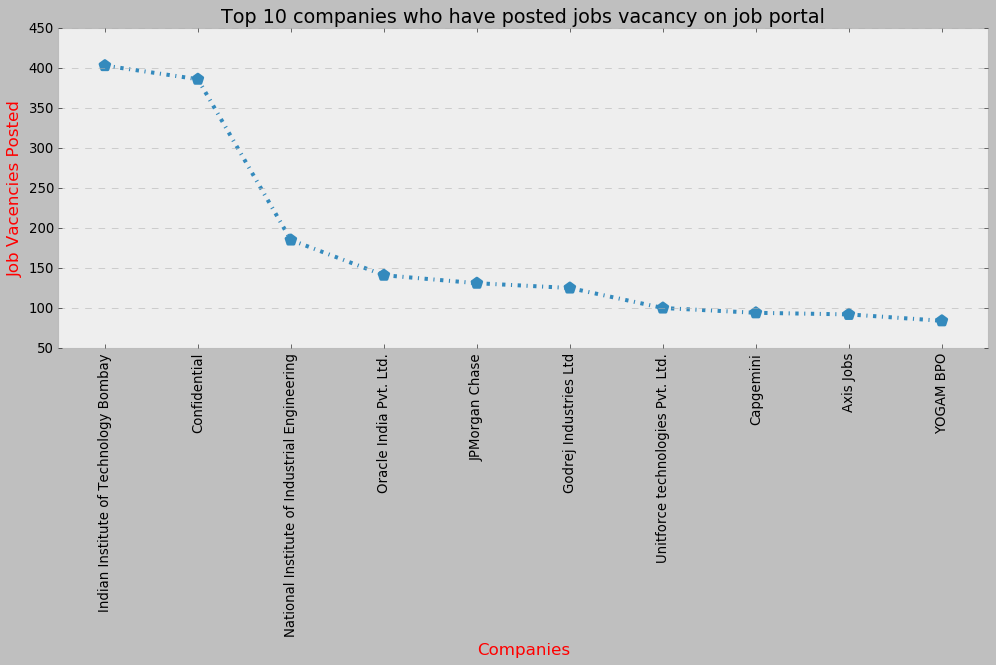

In [166]:
# showing graphically
plt.figure(figsize=(15,5))
plt.style.use('bmh')
sns.pointplot(data=top10_companies.toPandas().head(10),x='company',y='count',alpha=0.8,markers='p',linestyles='dashdot')
plt.xlabel('Companies', fontsize = 15, color = 'Red')
plt.ylabel('Job Vacencies Posted', fontsize = 15, color = 'Red')
plt.xticks(rotation =90);
plt.title("Top 10 companies who have posted jobs vacancy on job portal");
display()

In [135]:
# Function to show values on Bar
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

In [133]:
#Q)Top 10 industry sector in companies for which vacancy has been posted.
top10_sector = jobTable.groupBy('industry').count().orderBy(desc('count'))
top10_sector = top10_sector.persist()
top10_sector.show(10)

+--------------------+-----+
|            industry|count|
+--------------------+-----+
|IT-Software / Sof...| 8610|
|Education / Teach...| 1279|
|Banking / Financi...| 1196|
|BPO / Call Centre...| 1160|
|Recruitment / Sta...| 1067|
|Internet / Ecommerce|  693|
|Pharma / Biotech ...|  509|
|Medical / Healthc...|  473|
|Automobile / Auto...|  463|
|Construction / En...|  437|
+--------------------+-----+
only showing top 10 rows



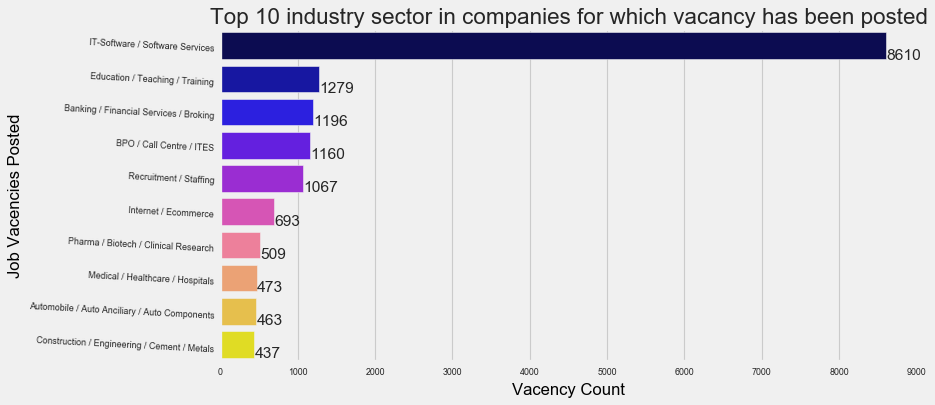

In [201]:
# showing graphically
plt.figure(figsize=(10,5))
plt.style.use('fivethirtyeight')

ax = sns.barplot(y='industry',x='count',data=top10_sector.toPandas().head(10),palette='gnuplot2')
#top10_sector.toPandas().head(10).plot.barh('industry',alpha=0.8)
show_values_on_bars(ax, "h", 1.3)
plt.xlabel('Vacency Count', fontsize = 15, color = 'black')
plt.ylabel('Job Vacencies Posted', fontsize = 15, color = 'black')
plt.yticks(rotation =-3);
plt.title("Top 10 industry sector in companies for which vacancy has been posted");
display()

In [284]:
#Q)Top 10 job Titles
top10_jobTitles = jobTable.groupBy('jobTitle').count().orderBy(desc('count'))
top10_jobTitles = top10_jobTitles.persist()
top10_jobTitles.show(10)

+--------------------+-----+
|            jobTitle|count|
+--------------------+-----+
|Business Developm...|   90|
|Business Developm...|   88|
|   Software Engineer|   77|
|     Project Manager|   64|
|   Android Developer|   64|
|        Web Designer|   60|
|      Content Writer|   58|
|Senior Software E...|   54|
|      Java Developer|   53|
|       PHP Developer|   53|
+--------------------+-----+
only showing top 10 rows



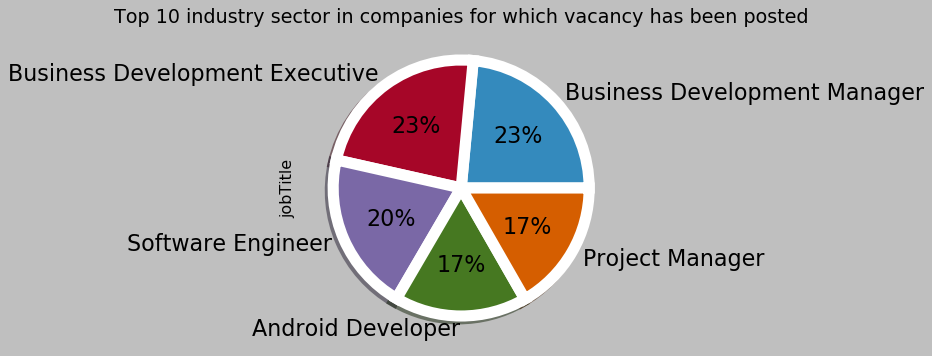

In [841]:
# Showing graphically
plt.figure(figsize=(15,5))
plt.style.use('bmh')
plt.subplot(121)
jobTable.toPandas()['jobTitle'].value_counts().head(5).plot.pie(autopct='%1.f%%',
                                                             wedgeprops={'linewidth':10,'edgecolor':'white'},
                                                             shadow=True,
                                                             fontsize=20)
plt.title("Top 10 industry sector in companies for which vacancy has been posted");
display()

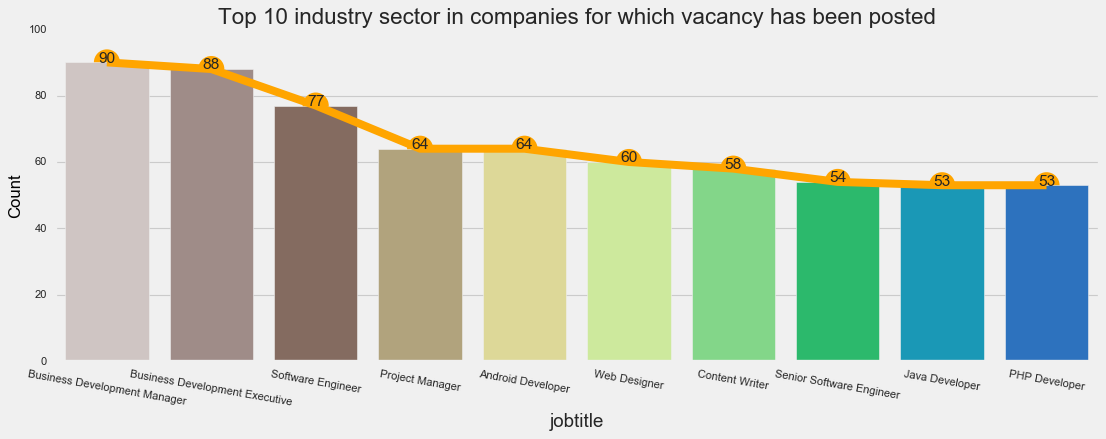

In [182]:
# showing graphically 
plt.figure(figsize=(15,5))
plt.style.use('seaborn-muted')

ax = sns.barplot(x='jobTtitle',y='count',data=top10_jobTitles.toPandas().head(10),palette='terrain_r')
sns.pointplot(x='jobTitle',y='count',data=top10_jobTitles.toPandas().head(10),color='orange',marker='*',markersize=3,linewidth=2)
show_values_on_bars(ax, "v", 1.9)

plt.ylabel('Count', fontsize = 15, color = 'black')
plt.ylabel('Count', fontsize = 15, color = 'black')
plt.xticks(rotation = -10);
plt.title("Top 10 industry sector in companies for which vacancy has been posted");
display()

In [202]:
#Q)Total number of Job Sector in industry who posted job
jobTable.select('industry').drop_duplicates().count()

64

In [203]:
#Q)Total number of companies who had posted job
jobTable.select('company').drop_duplicates().count()

8135

In [204]:
#Q)Total number of jobTitles posted on a job
jobTable.select('jobTitle').drop_duplicates().count()

16650

In [205]:
#Q)Top 10 skill sector that companies are looking for
top10_skillset = jobTable.groupBy('skills').count().orderBy(desc('count'))
top10_skillset = top10_skillset.persist()
top10_skillset.toPandas().head(10)

,skills,count
0,IT Software - Application Programming,5590
1,Sales,2754
2,ITES,1503
3,Teaching,1063
4,HR,888
5,Accounts,840
6,Marketing,822
7,Production,645
8,unknown,505
9,Medical,401


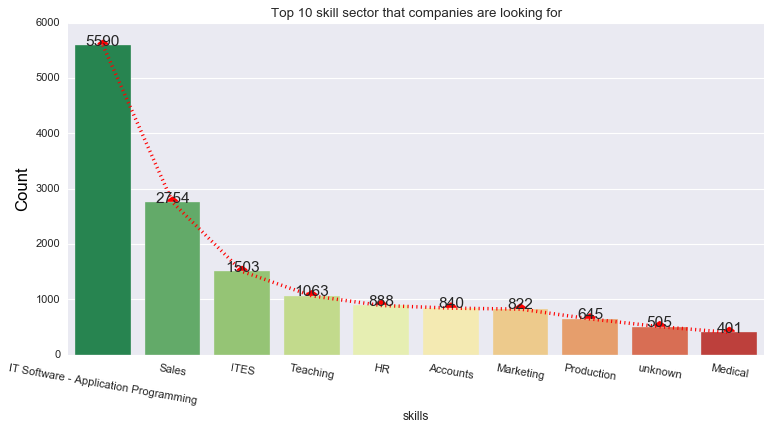

In [239]:
# showing graphically
plt.figure(figsize=(10,5))
plt.style.use('seaborn')
sns.pointplot(x='skills',y='count',data=top10_skillset.toPandas().head(10),alpha=0.8,markers='p',linestyles=':',color='red')
ax = sns.barplot(x='skills',y='count',data=top10_skillset.toPandas().head(10),palette='RdYlGn_r')
show_values_on_bars(ax, "v", 1.9)

plt.ylabel('Count', fontsize = 15, color = 'black')
plt.xticks(rotation = -10);
plt.title("Top 10 skill sector that companies are looking for");
display()

In [241]:
#Q)Top 10 job location that companies are giving
top10_jobLocation = jobTable.groupBy('jobLocation').count().orderBy(desc('count'))
top10_jobLocation.show(10)

+--------------------+-----+
|         jobLocation|count|
+--------------------+-----+
| Bengaluru/Bangalore| 3513|
|              Mumbai| 2267|
|           Bengaluru| 1355|
|Hyderabad / Secun...| 1181|
|             Chennai| 1111|
|           Hyderabad|  874|
|               Delhi|  736|
|             Gurgaon|  704|
|               Noida|  695|
|     Mumbai , Mumbai|  500|
+--------------------+-----+
only showing top 10 rows



In [243]:
# We need to replace and fix the issue of some row values with a common name which are similar in looking
jobTable = jobTable.withColumn('jobLocation', F.when(col('jobLocation')=='Bengaluru/Bangalore','Bangalore').
                     when(col('jobLocation')=='Bengaluru','Bangalore').
                     when(col('jobLocation')=='Hyderabad / Secunderabad','Hyderabad').
                     when(col('jobLocation')=='Mumbai , Mumbai','Mumbai').
                     when(col('jobLocation')=='Delhi','NCR').
                     when(col('jobLocation')=='Delhi/NCR(National Capital Region)','NCR').
                     when(col('jobLocation')=='Noida','NCR').
                     when(col('jobLocation')=='Gurgaon','NCR').
                     when(col('jobLocation')=='Noida , Noida/Greater Noida','NCR').
                     when(col('jobLocation')=='Ghaziabad','NCR').
                     when(col('jobLocation')=='Delhi , Delhi','NCR').
                     when(col('jobLocation')=='Delhi/NCR(National Capital Region) , Gurgaon','NCR').
                     when(col('jobLocation')=='NCR , NCR','NCR').
                     when(col('jobLocation')=='NCR/NCR(National Capital Region)','NCR').
                     when(col('jobLocation')=='NCR , NCR/Greater NCR','NCR').
                     when(col('jobLocation')=='NCR/NCR(National Capital Region) , NCR','NCR').
                     when(col('jobLocation')=='NCR , NCR/NCR(National Capital Region)','NCR').
                     when(col('jobLocation')=='Bangalore , Bangalore / Bangalore','Bangalore').
                     when(col('jobLocation')=='Bangalore , karnataka','Bangalore').
                     when(col('jobLocation')=='NCR/NCR(National Capital Region)','NCR').
                     when(col('jobLocation')=='NCR/Greater NCR','NCR').
                     when(col('jobLocation')=='NCR , NCR/NCR(National Capital Region)','NCR').
                     when(col('jobLocation')=='Bengaluru/Bangalore , Bengaluru / Bangalore','Bangalore').
                     when(col('jobLocation')=='Gurgaon , Gurgaon','NCR')                           
                    .otherwise(jobTable['jobLocation']))

In [244]:
top10_jobLocation = jobTable.groupBy('jobLocation').count().orderBy(desc('count'))
top10_jobLocation = top10_jobLocation.persist()
top10_jobLocation.toPandas().head(10)

,jobLocation,count
0,Bangalore,5222
1,NCR,3456
2,Mumbai,2767
3,Hyderabad,2055
4,Chennai,1111
5,unknown,493
6,"Bengaluru/Bangalore , Chennai , Hyderabad / Se...",115
7,"Bengaluru/Bangalore , Hyderabad / Secunderabad",92
8,"Bengaluru, Hyderabad",78
9,"Bengaluru/Bangalore , Chennai",74


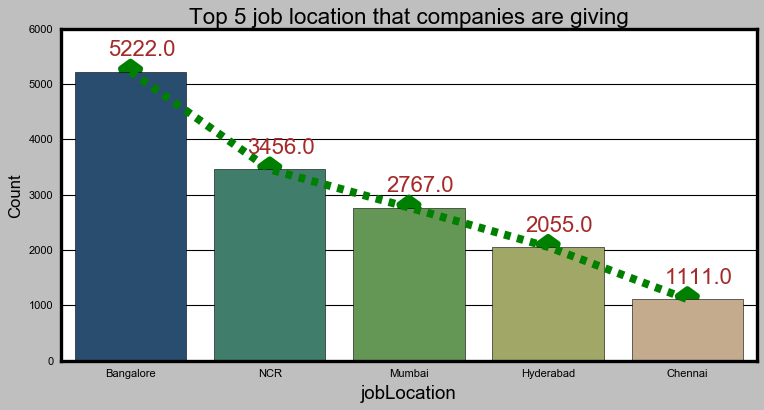

In [292]:
# showing graphically
plt.figure(figsize=(10,5))
plt.style.use('grayscale')

sns.pointplot(x='jobLocation',y='count',data=top10_jobLocation.toPandas().head(5),color='green',markersize=2,alpha=0.8,markers='p',linestyles='dashed')
ax = sns.barplot(x='jobLocation',y='count',data=top10_jobLocation.toPandas().head(5),palette='gist_earth')
for p in ax.patches:
    ax.annotate(format(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),
               ha='center',va='center',xytext=(10,20),textcoords='offset points',color='brown',fontsize=20)
   
plt.ylabel('Count', fontsize = 15, color = 'black')
plt.xticks(rotation = 0);
plt.title("Top 5 job location that companies are giving");
display()

In [293]:
# We need to replace and fix the issue of some row values with a common name which are similar in looking and converting to initcap
jobTable = jobTable.withColumn('payRate',initcap(jobTable['payRate']))

jobTable = jobTable.withColumn('payRate', F.when(col('payRate')=='Best In Industry','As Per Industry Standards').
                                           when(col('payRate')=='Best In The Industry','As Per Industry Standards')
                                           .otherwise(jobTable['payRate']))

In [295]:
#Q)Top 10 pay rate given by company
top10_payRate = jobTable.groupBy('payRate').count().orderBy(desc('count'))
top10_payRate = top10_payRate.persist()
top10_payRate.toPandas().head(10)

,payRate,count
0,Not Disclosed By Recruiter,15030
1,As Per Industry Standards,391
2,Pay Band: Pb4 (rs.3740067000) With Academic Gr...,121
3,Pay Band: Pb4 (rs.3740067000) With Academic Gr...,116
4,Pay Band: Pb3 (rs.15600-39100) With Academic G...,84
5,"2,00,000 - 4,00,000 P.a",64
6,Pay Scale: Pb-3 (rs.i5600-39100) With Agp Of R...,63
7,"3,00,000 - 8,00,000 P.a",61
8,"1,00,000 - 3,00,000 P.a",57
9,"3,00,000 - 5,00,000 P.a",56


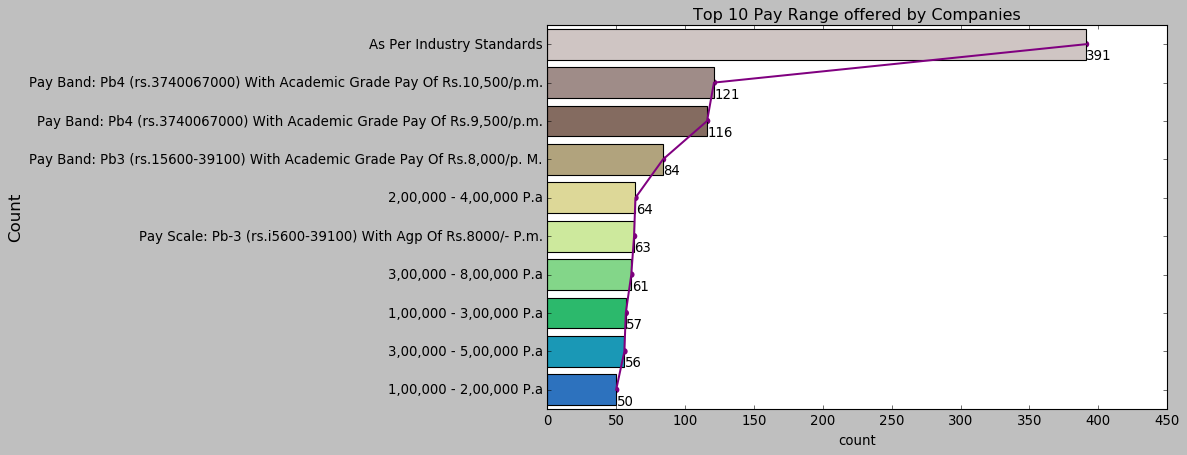

In [316]:
# showing graphically
top10Payrange = top10_payRate.filter(top10_payRate['payRate']!='Not Disclosed By Recruiter')
plt.style.use('classic')

plt.figure(figsize=(10,6))
sns.pointplot(y='payRate',x='count',data=top10Payrange.toPandas().head(10),color='purple')
ax = sns.barplot(y='payRate',x='count',data=top10Payrange.toPandas().head(10),palette='terrain_r')
show_values_on_bars(ax, "h", 0.3)    
plt.ylabel('Count', fontsize = 15, color = 'black')
plt.yticks(rotation = 0);
plt.title("Top 10 Pay Range offered by Companies");
display()

In [409]:
# Creating a average pay scale column and average experience column

jobTable = jobTable.withColumn('avg_pay',(jobTable['min_pay'] + jobTable['max_pay'])/2)
jobTable = jobTable.withColumn('avg_experience',(jobTable['min_experience'] + jobTable['max_experience'])/2)

In [410]:
#Q))Avg pay wrt skills
Top10AvgPay=jobTable.groupBy('skills').agg({'avg_pay':'sum'}).select('skills',round('sum(avg_pay)').alias('totalAvgPay')).orderBy(desc('totalAvgPay'))
Top10AvgPay = Top10AvgPay.persist()
Top10AvgPay.toPandas().head(10)

,skills,totalAvgPay
0,IT Software - Application Programming,659129803.0
1,Sales,454861484.0
2,ITES,247443259.0
3,Accounts,179898105.0
4,HR,114720639.0
5,Production,108625468.0
6,Marketing,88838189.0
7,unknown,75382348.0
8,Medical,59365288.0
9,Analytics & Business Intelligence,52750127.0


In [58]:
Top10AvgPay.agg({'totalAvgPay':'avg'}).select(round('avg(totalAvgPay)').cast('integer').alias('totalAvgPay')).show()

+-----------+
totalAvgPay|
+-----------+
 21709592|
+-----------+

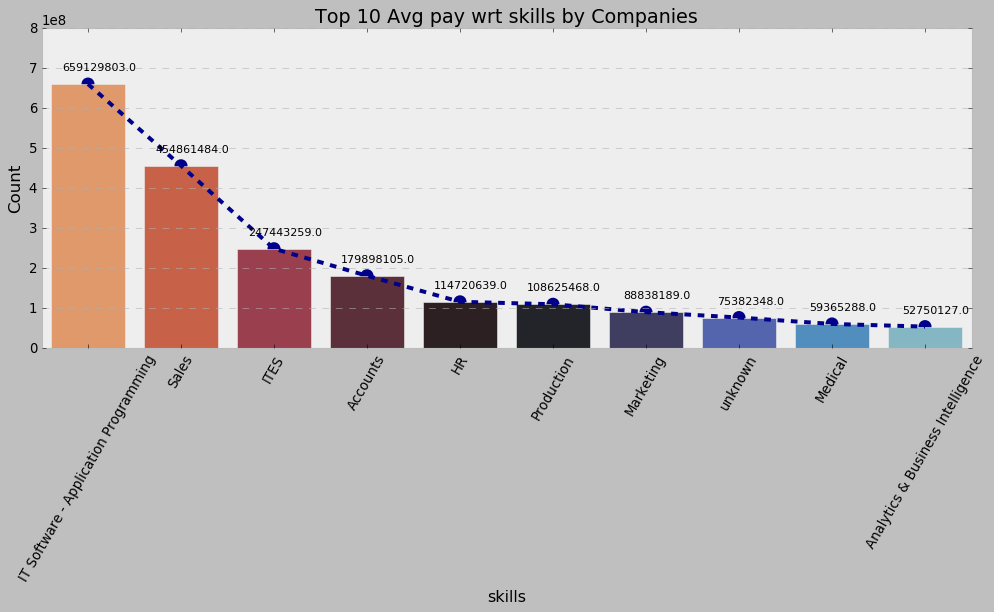

In [422]:
# showing graphically 
plt.figure(figsize=(15,5))
plt.style.use('bmh')

ax = sns.barplot(x='skills',y='totalAvgPay',data=Top10AvgPay.toPandas().head(10),palette='icefire_r')
sns.pointplot(x='skills',y='totalAvgPay',data=Top10AvgPay.toPandas().head(10),color='darkblue',marker='*',linestyles='--',markersize=3,linewidth=5)
#show_values_on_bars(ax, "v", 1.9)
for p in ax.patches:
    ax.annotate(format(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),
               ha='center',va='center',xytext=(10,15),textcoords='offset points',color='black',fontsize=10)
 

plt.ylabel('Count', fontsize = 15, color = 'black')
plt.xticks(rotation = 60);
plt.title("Top 10 Avg pay wrt skills by Companies");
display()

In [431]:
#Q)Maximum pay wrt industry
Top10PayingIndustry = jobTable.groupBy('company','industry','skills').agg({'max_pay':'max'}).select('company','industry','skills',round('max(max_pay)').alias('maxSalaryOffered')).orderBy(desc('max(max_pay)'))
Top10PayingIndustry = Top10PayingIndustry.persist()
Top10PayingIndustry.toPandas().head(10)

,company,industry,skills,maxSalaryOffered
0,V- Konnect Associates,Retail / Wholesale,Accounts,8000000
1,Vanguard Human Resource Consultant Pvt Ltd,IT-Software / Software Services,IT Software - Application Programming,7000000
2,Premium-Jobs hiring for Internet/ecomm,Courier / Transportation / Freight / Warehousing,Sales,6000000
3,Green And Wise,Medical / Healthcare / Hospitals,Sales,5000000
4,Bee5 Manpower Consulting,IT-Software / Software Services,IT Software - Mobile,5000000
5,ViXi IT Solutions hiring for IBM India Private...,IT-Software / Software Services,IT Software - Application Programming,5000000
6,Leading client of HR Next,IT-Software / Software Services,HR,5000000
7,Vesat Management Consultants Pvt. Ltd hiring f...,Industrial Products / Heavy Machinery,Top Management,5000000
8,Careernet Technologies Pvt Ltd hiring for Client,IT-Software / Software Services,IT Software - Application Programming,5000000
9,Kaay Labs,IT-Software / Software Services,IT Software - Application Programming,5000000


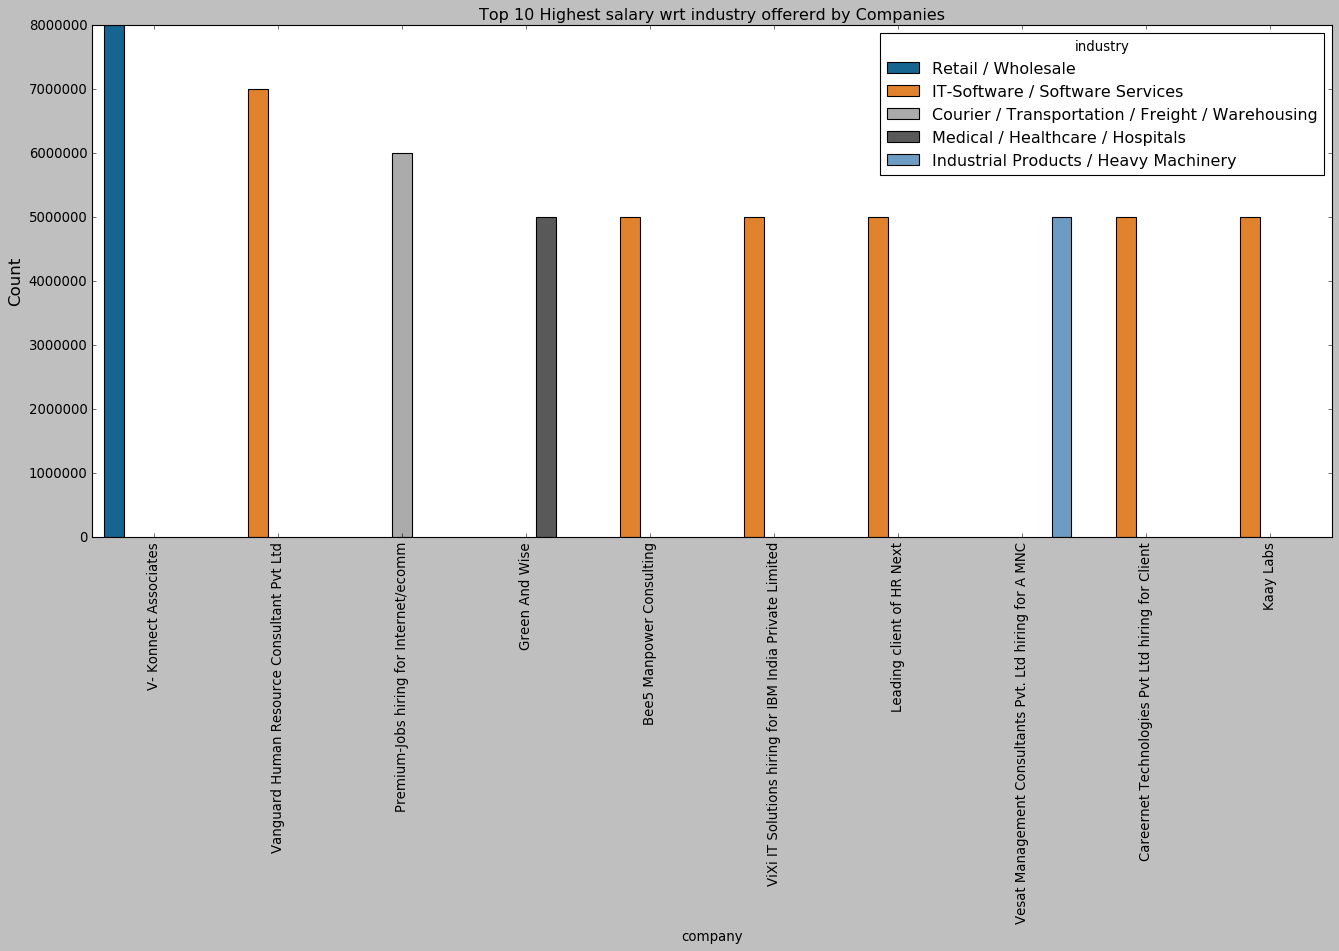

In [459]:
# showing graphically 
plt.figure(figsize=(20,8))
plt.style.use('tableau-colorblind10')

sns.barplot(data=Top10PayingIndustry.toPandas().head(10),x='company',y='maxSalaryOffered',hue='industry')
display()

plt.ylabel('Count', fontsize = 15, color = 'black')
plt.xticks(rotation = 90);
plt.title("Top 10 Highest salary wrt industry offererd by Companies");
display()

In [458]:
#Q)Minimum pay wrt industry
Top10LessPayingIndus = jobTable.groupBy('company','industry','skills').agg({'min_pay':'min'}).select('company','industry','skills',round('min(min_pay)').alias('minSalaryOffered')).orderBy(desc('min(min_pay)'))
Top10LessPayingIndus = Top10LessPayingIndus.persist()
Top10LessPayingIndus.toPandas().head(10)

,company,industry,skills,minSalaryOffered
0,Premium-Jobs hiring for Startup,Accounting / Finance,Accounts,5500000
1,Live connections,Electricals / Switchgears,Engineering Design,5000000
2,Vesat Management Consultants Pvt. Ltd hiring f...,Industrial Products / Heavy Machinery,Top Management,5000000
3,Vanguard Human Resource Consultant Pvt Ltd,IT-Software / Software Services,IT Software - Application Programming,5000000
4,V- Konnect Associates,Retail / Wholesale,Accounts,5000000
5,Premium-Jobs hiring for Internet/ecomm,Courier / Transportation / Freight / Warehousing,Sales,5000000
6,Merrin and Associates hiring for an ecommerce ...,Retail / Wholesale,Marketing,5000000
7,Search Ends hiring for Leading Company in Oil ...,Oil and Gas / Energy / Power / Infrastructure,Top Management,5000000
8,LINKTAG hiring for MNC located in Bangalore,IT-Software / Software Services,IT Software - Application Programming,5000000
9,Inncon Business Technology Consulting hiring f...,IT-Software / Software Services,IT Software - System Programming,4500000


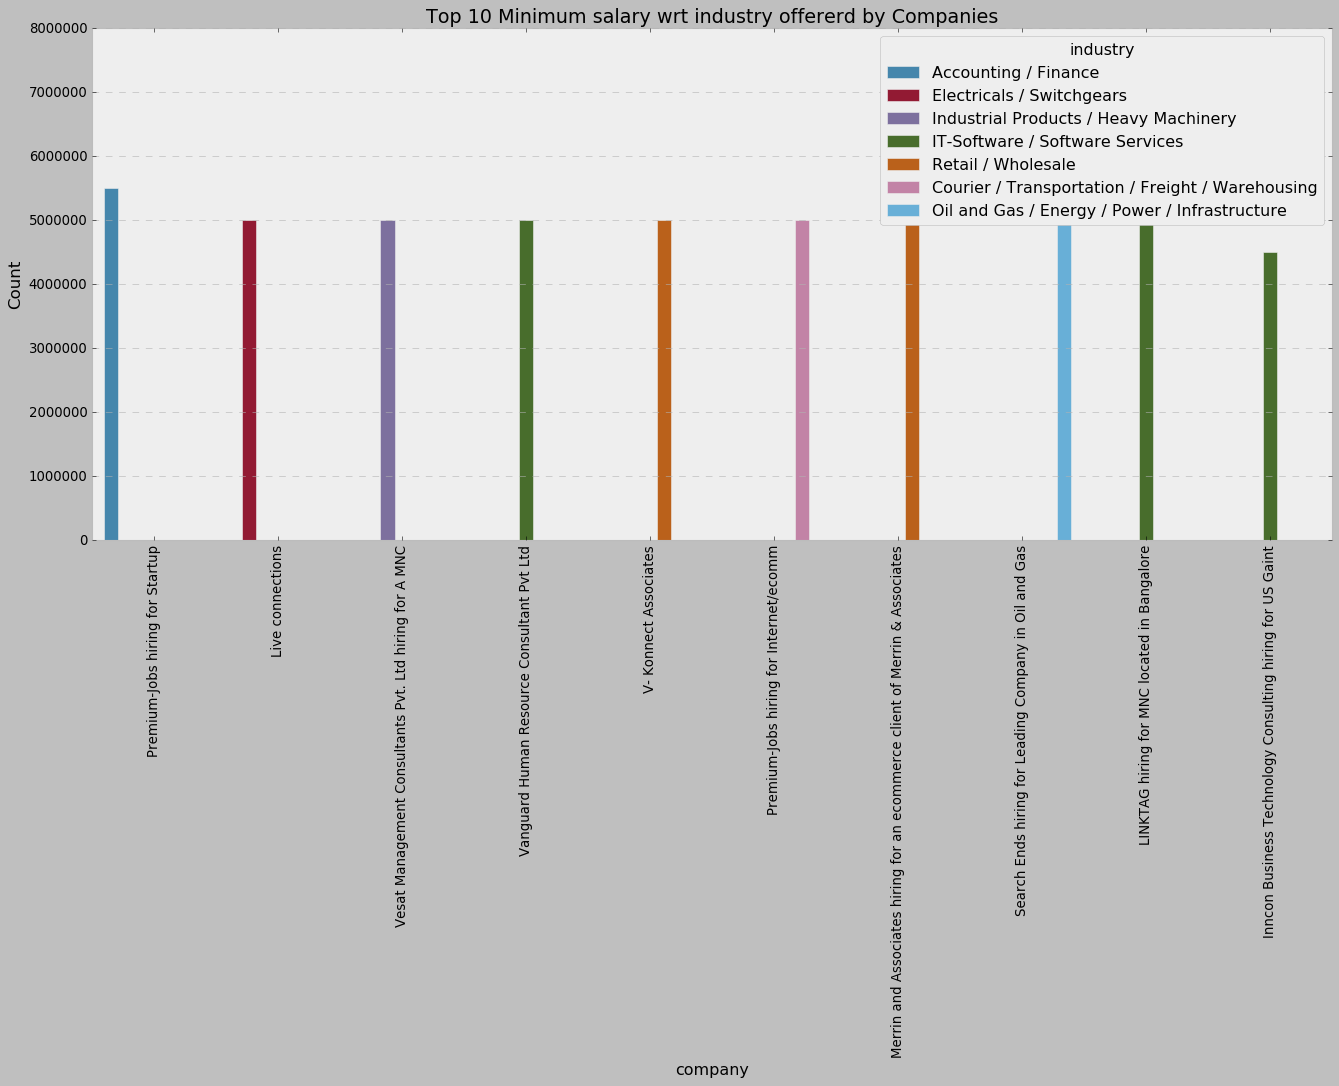

In [474]:
#JobPostedDistribution.toPandas().plot(x='MonthName',y='count',kind='bar')

# showing graphically 
plt.figure(figsize=(20,8))
plt.style.use('bmh')

sns.barplot(data=Top10LessPayingIndus.toPandas().head(10),x='company',y='minSalaryOffered',hue='industry')
plt.ylabel('Count', fontsize = 15, color = 'black')
plt.xticks(rotation = 90);
plt.ylim((0,8000000))
  
plt.title("Top 10 Minimum salary wrt industry offererd by Companies");
display()

In [477]:
jobTable = jobTable.coalesce(100)

In [478]:
jobTable.rdd.getNumPartitions()

100

In [482]:
#Q)Top 10 Avg pay wrt job title and industry
Top10AvgPayingIndus = jobTable.groupBy('company','skills','jobtitle').agg({'avg_pay':'sum'}).select('company','skills','jobtitle',round('sum(avg_pay)').alias('avgPay')).orderBy(desc('avgPay'))
Top10AvgPayingIndus = Top10AvgPayingIndus.persist()
Top10AvgPayingIndus.toPandas().head(10)

,company,skills,jobtitle,avgPay
0,YOGAM BPO,ITES,Medical Coding Transcription - We Will Help Yo...,11750000.0
1,V- Konnect Associates,Accounts,CFO,6500000.0
2,Vanguard Human Resource Consultant Pvt Ltd,IT Software - Application Programming,Appian Developer-(2 to 6yrs),6000000.0
3,ANRI SOLUTIONS HR SERVICES PVT LTD hiring for ...,Accounts,Requirement OF Manager/ Sr. Manager IN BIG 4,5500000.0
4,Premium-Jobs hiring for Internet/ecomm,Sales,National Head Institutional Sales (bd/sales),5500000.0
5,LINKTAG hiring for MNC located in Bangalore,IT Software - Application Programming,Java Application Support Consultant,5000000.0
6,Vesat Management Consultants Pvt. Ltd hiring f...,Top Management,Business Head-industrial Consumable-mnc-chennai,5000000.0
7,Search Ends hiring for Leading Company in Oil ...,Top Management,Director Sales & Marketing,5000000.0
8,Kaay Labs,IT Software - Application Programming,Immediate Job Opening -- Sharepoint,5000000.0
9,Merrin and Associates hiring for an ecommerce ...,Marketing,Brand Director,5000000.0


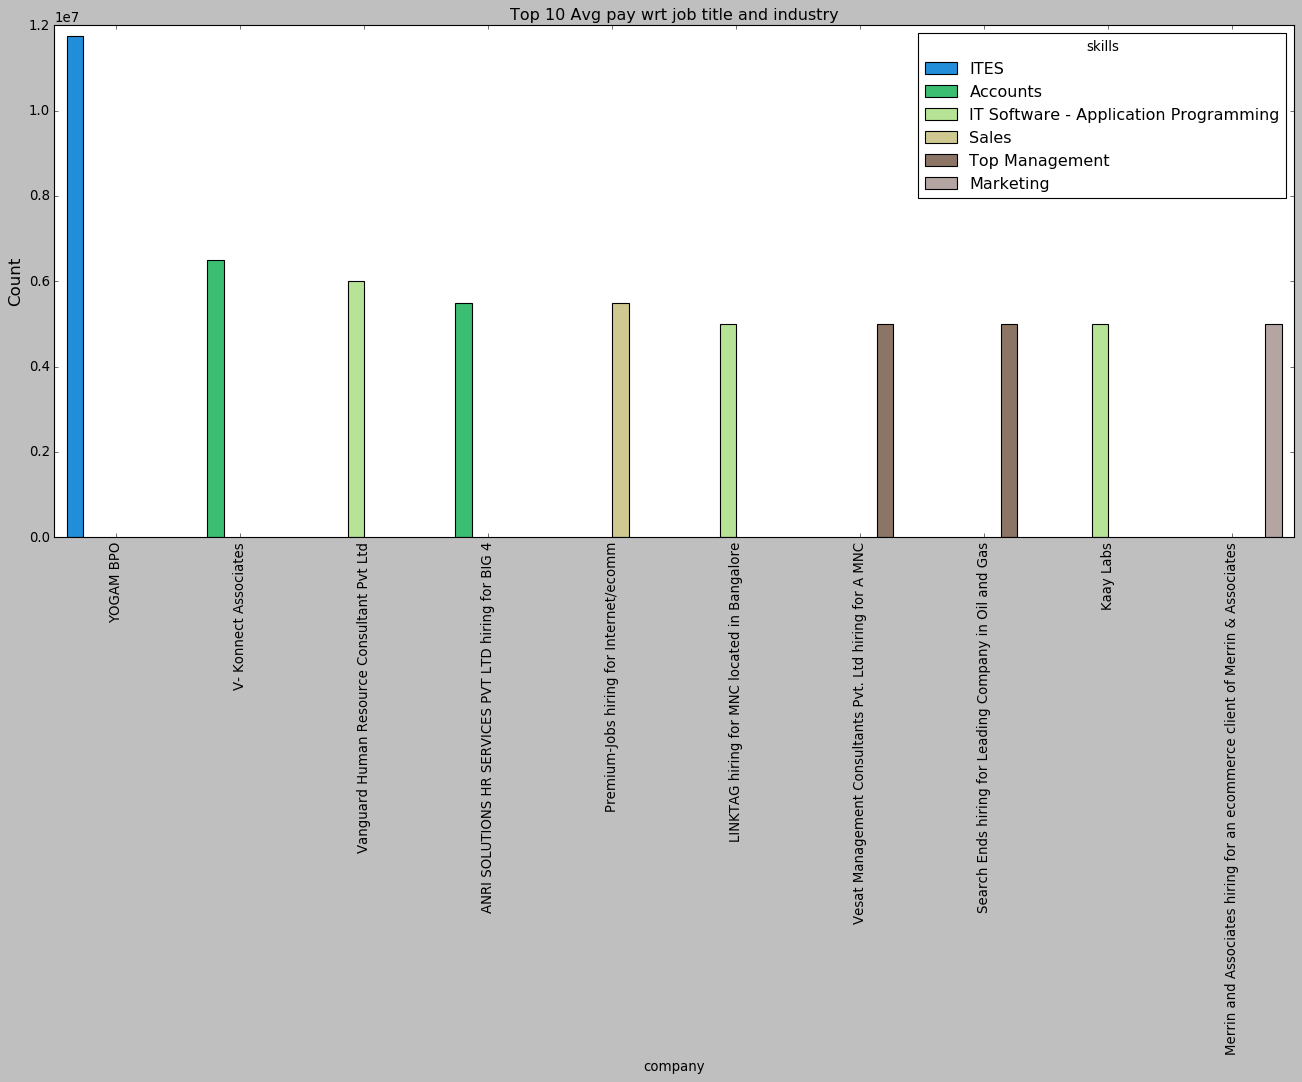

In [506]:
# Showing graphically 
plt.figure(figsize=(20,8))
plt.style.use('fast')
    
sns.barplot(data=Top10AvgPayingIndus.toPandas().head(10),x='company',y='avgPay',hue='skills',palette='terrain')
plt.ylabel('Count', fontsize = 15, color = 'black')
plt.xticks(rotation = 90);
#plt.ylim((0,8000000))
  
plt.title("Top 10 Avg pay wrt job title and industry");
display()

In [503]:
#Q)Top 10 Average number of positions opened wrt skills and industry
Top10AvgnumPosition = jobTable.groupBy('skills','industry').avg('numberofpositions').orderBy(desc('avg(numberofpositions)')).select('skills','industry',round('avg(numberofpositions)', 0).alias('avgNumPositions'))
Top10AvgnumPosition = Top10AvgnumPosition.persist()
Top10AvgnumPosition.toPandas().head(10)

,skills,industry,avgNumPositions
0,ITES,Fresher / Trainee / Entry Level,1200.0
1,ITES,Medical / Healthcare / Hospitals,516.0
2,ITES,Pharma / Biotech / Clinical Research,287.0
3,Travel,Travel / Hotels / Restaurants / Airlines / Rai...,119.0
4,HR,Advertising / PR / MR / Event Management,114.0
5,Executive Assistant,Travel / Hotels / Restaurants / Airlines / Rai...,112.0
6,ITES,BPO / Call Centre / ITES,97.0
7,Medical,Medical / Healthcare / Hospitals,74.0
8,unknown,Pharma / Biotech / Clinical Research,72.0
9,Executive Assistant,Fresher / Trainee / Entry Level,66.0


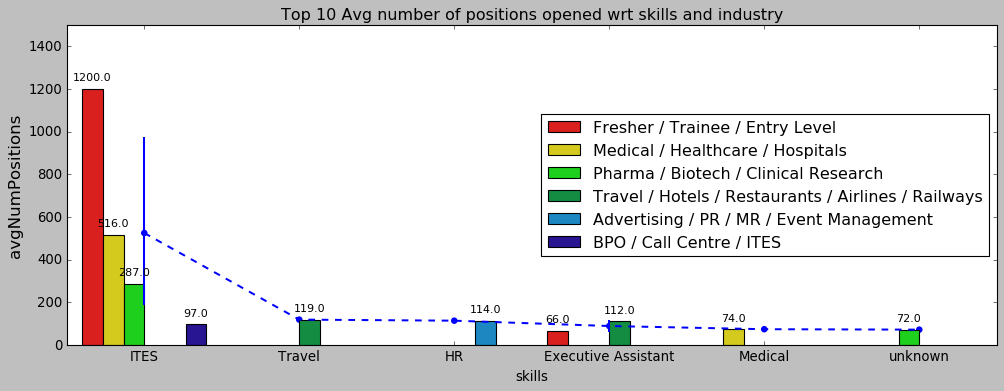

In [525]:
# showing graphically 
plt.figure(figsize=(15,5))
plt.style.use('fast')

ax = sns.barplot(x='skills',y='avgNumPositions',data=Top10AvgnumPosition.toPandas().head(10),hue='industry',palette='nipy_spectral_r')
sns.pointplot(x='skills',y='avgNumPositions',data=Top10AvgnumPosition.toPandas().head(10),color='blue',linestyles='--',markersize=3,linewidth=2)

for p in ax.patches:
    ax.annotate(format(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),
               ha='center',va='center',xytext=(0,10),textcoords='offset points',color='black',fontsize=10)

plt.ylabel('avgNumPositions', fontsize = 15, color = 'black')
plt.xticks(rotation = 0);
plt.ylim((0,1500))
plt.title("Top 10 Avg number of positions opened wrt skills and industry");
plt.legend(loc='right')
display()

In [526]:
#Q)Top 10 Average numberofpositions wrt experience and skills in IT
expression = r'IT\s\w+'

Top10AvgnumPosExp = jobTable.filter(jobTable['skills'].rlike(expression)).groupBy('skills','industry','experience').avg('numberofpositions').orderBy(desc('avg(numberofpositions)')).select('skills','industry','experience',round('avg(numberofpositions)', 0).alias('avgNumberOfPositions'))
Top10AvgnumPosExp = Top10AvgnumPosExp.persist()
Top10AvgnumPosExp.toPandas().head(10)

,skills,industry,experience,avgNumberOfPositions
0,IT Software - Application Programming,IT-Software / Software Services,0 - 1 yrs,128.0
1,IT Software - Application Programming,BPO / Call Centre / ITES,0 - 5 yrs,100.0
2,IT Hardware,Semiconductors / Electronics,0 - 3 yrs,92.0
3,IT Software - Application Programming,Automobile / Auto Anciliary / Auto Components,0 - 3 yrs,89.0
4,IT Software - Application Programming,BPO / Call Centre / ITES,0 - 4 yrs,50.0
5,IT Hardware,Semiconductors / Electronics,0 - 5 yrs,40.0
6,IT Hardware,Telecom/ISP /,1 - 6 yrs,40.0
7,IT Software - Embedded,Travel / Hotels / Restaurants / Airlines / Rai...,1 - 5 yrs,34.0
8,IT Hardware,IT-Software / Software Services,0 - 1 yrs,33.0
9,IT Software - Network Administration,IT-Hardware & Networking,1 - 3 yrs,30.0


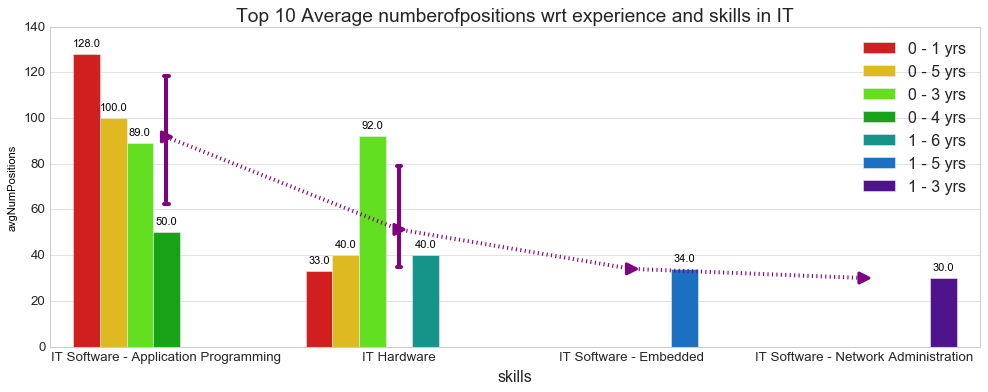

In [626]:
# showing graphically 
plt.figure(figsize=(15,5))
plt.style.use('seaborn-whitegrid')

ax = sns.barplot(x='skills',y='avgNumberOfPositions',data=Top10AvgnumPosExp.toPandas().head(10),hue='experience',palette='nipy_spectral_r')
sns.pointplot(x='skills',y='avgNumberOfPositions',data=Top10AvgnumPosExp.toPandas().head(10),color='purple',capsize=.02,markers='>',linestyles='dotted',markersize=3,linewidth=2)

for p in ax.patches:
    ax.annotate(format(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),
               ha='center',va='center',xytext=(0,10),textcoords='offset points',color='black',fontsize=10)

plt.ylabel('avgNumPositions', fontsize = 10, color = 'black')
plt.xticks(rotation = 0);
plt.title("Top 10 Average numberofpositions wrt experience and skills in IT");
plt.legend(loc='upper right')
display()

In [555]:
#Q)Average numberofpositions wrt experience and skills in ITES
expression = r'ITES'

Top15ItesAvgNumPos =jobTable.filter(jobTable['skills'].rlike(expression)).groupBy('industry','experience').avg('numberofpositions').orderBy(desc('avg(numberofpositions)')).select('industry','experience',round('avg(numberofpositions)', 0).alias('avgNumberOfPositions'))
Top15ItesAvgNumPos = Top15ItesAvgNumPos.persist()
Top15ItesAvgNumPos.toPandas().head(15)

,industry,experience,avgNumberOfPositions
0,Pharma / Biotech / Clinical Research,0 - 0 yrs,1200.0
1,Fresher / Trainee / Entry Level,0 - 1 yrs,1200.0
2,Medical / Healthcare / Hospitals,0 - 5 yrs,1103.0
3,Medical / Healthcare / Hospitals,0 - 0 yrs,1017.0
4,Pharma / Biotech / Clinical Research,0 - 1 yrs,650.0
5,Medical / Healthcare / Hospitals,0 - 1 yrs,580.0
6,BPO / Call Centre / ITES,0 - 1 yrs,486.0
7,BPO / Call Centre / ITES,0 - 5 yrs,173.0
8,BPO / Call Centre / ITES,0 - 0 yrs,121.0
9,KPO / Research / Analytics,0 - 4 yrs,50.0


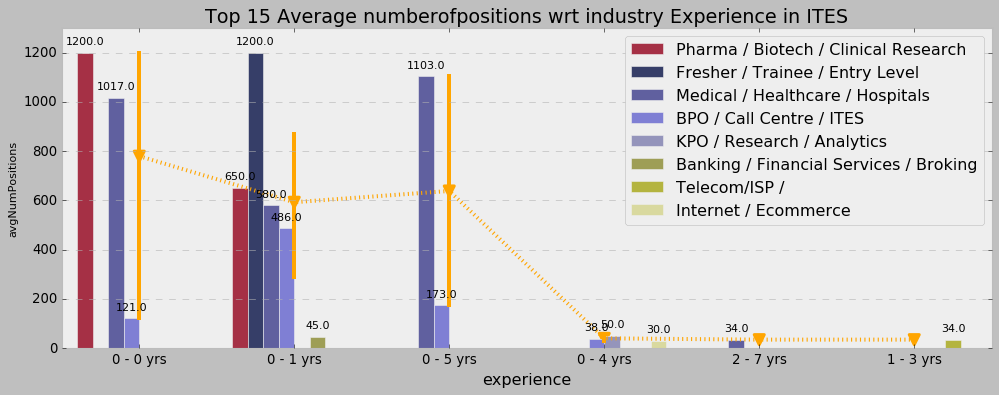

In [615]:
# showing graphically 
plt.figure(figsize=(15,5))
plt.style.use('bmh')

ax = sns.barplot(x='experience',y='avgNumberOfPositions',data=Top15ItesAvgNumPos.toPandas().head(15),hue='industry',palette='gist_stern')
sns.pointplot(x='experience',y='avgNumberOfPositions',data=Top15ItesAvgNumPos.toPandas().head(15),markers='',color='orange',linestyles='dotted',markersize=3,linewidth=2)

for p in ax.patches:
    ax.annotate(format(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),
               ha='center',va='center',xytext=(0,10),textcoords='offset points',color='black',fontsize=10)

plt.ylabel('avgNumPositions', fontsize = 10, color = 'black')
plt.xticks(rotation = 0);
plt.ylim((0,1300))
plt.title("Top 15 Average numberofpositions wrt industry Experience in ITES");
plt.legend(loc='upper right')
display()

In [654]:
#Average numberofpositions wrt experience and skills in Sales
Top15SalesAvgNumPos =jobTable.filter(jobTable['skills']=='Sales').groupBy('industry','experience').avg('numberofpositions').orderBy(desc('avg(numberofpositions)')).select('industry','experience',round('avg(numberofpositions)', 0).alias('avgNumberOfPositions'))
Top15SalesAvgNumPos = Top15SalesAvgNumPos.persist()
Top15SalesAvgNumPos.toPandas().head(15)

,industry,experience,avgNumberOfPositions
0,Internet / Ecommerce,0 - 5 yrs,302.0
1,Advertising / PR / MR / Event Management,0 - 1 yrs,302.0
2,Advertising / PR / MR / Event Management,0 - 2 yrs,300.0
3,IT-Software / Software Services,0 - 5 yrs,221.0
4,Telecom/ISP,0 - 3 yrs,100.0
5,Media / Entertainment / Internet,0 - 3 yrs,76.0
6,Insurance,0 - 2 yrs,67.0
7,Insurance,1 - 6 yrs,42.0
8,Retail / Wholesale,0 - 1 yrs,41.0
9,Banking / Financial Services / Broking,0 - 0 yrs,40.0


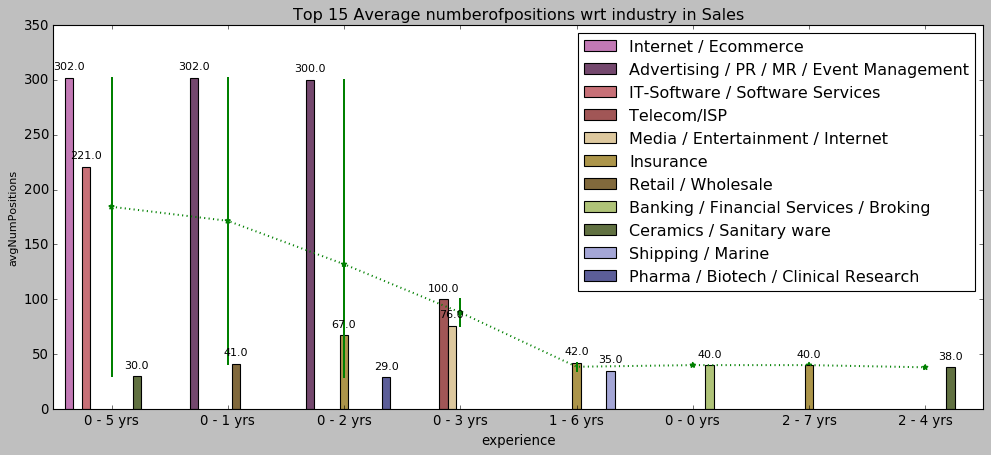

In [706]:
# showing graphically 
plt.figure(figsize=(15,6))
plt.style.use('seaborn-colorblind')

ax = sns.barplot(x='experience',y='avgNumberOfPositions',data=Top15SalesAvgNumPos.toPandas().head(15),hue='industry',palette='tab20b_r')
sns.pointplot(x='experience',y='avgNumberOfPositions',data=Top15SalesAvgNumPos.toPandas().head(15),markers='*',color='green',linestyles='dotted',markersize=3,linewidth=2)

for p in ax.patches:
    ax.annotate(format(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),
               ha='center',va='center',xytext=(0,10),textcoords='offset points',color='black',fontsize=10)

plt.ylabel('avgNumPositions', fontsize = 10, color = 'black')
plt.xticks(rotation = 0);
plt.title("Top 15 Average numberofpositions wrt industry in Sales");
plt.legend(loc='upper right')
display()

In [701]:
# Average numberofpositions wrt experience and skills in HR
Top10HrAvgNumPos = jobTable.filter(jobTable['skills']=='HR').groupBy('industry','experience').avg('numberofpositions').orderBy(desc('avg(numberofpositions)')).select('industry','experience',round('avg(numberofpositions)', 0).alias('avgNumberOfPositions'))
Top10HrAvgNumPos = Top10HrAvgNumPos.persist()
Top10HrAvgNumPos.toPandas().head(10)

,industry,experience,avgNumberOfPositions
0,Advertising / PR / MR / Event Management,0 - 3 yrs,300.0
1,Advertising / PR / MR / Event Management,0 - 1 yrs,300.0
2,Advertising / PR / MR / Event Management,0 - 5 yrs,75.0
3,Media / Entertainment / Internet,0 - 3 yrs,20.0
4,BPO / Call Centre / ITES,5 - 10 yrs,20.0
5,Courier / Transportation / Freight / Warehousing,0 - 5 yrs,15.0
6,Real Estate / Property,0 - 1 yrs,15.0
7,Banking / Financial Services / Broking,15 - 25 yrs,15.0
8,Recruitment / Staffing,0 - 3 yrs,14.0
9,Travel / Hotels / Restaurants / Airlines / Rai...,0 - 3 yrs,12.0


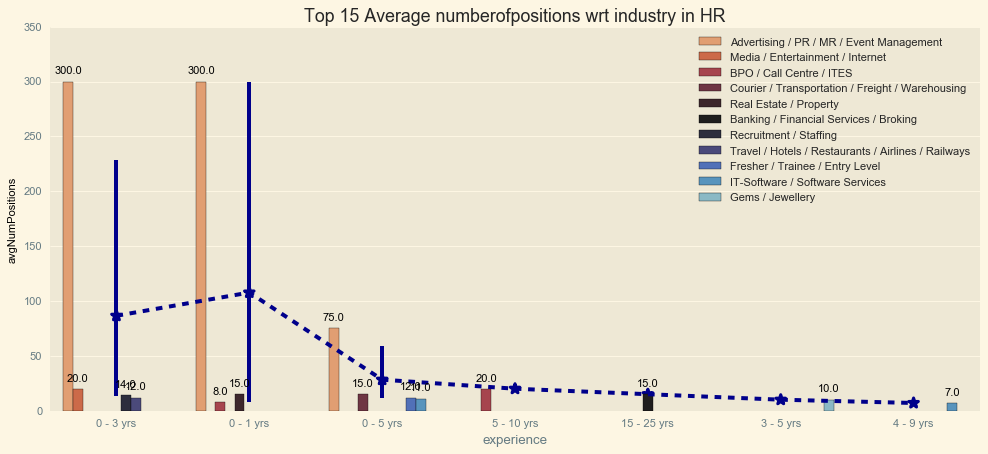

In [721]:
# showing graphically 
plt.figure(figsize=(15,6))
plt.style.use('Solarize_Light2')

ax = sns.barplot(x='experience',y='avgNumberOfPositions',data=Top10HrAvgNumPos.toPandas().head(15),hue='industry',palette='icefire_r')
sns.pointplot(x='experience',y='avgNumberOfPositions',data=Top10HrAvgNumPos.toPandas().head(15),markers='*',color='darkblue',linestyles='dashed',markersize=3,linewidth=5)

for p in ax.patches:
    ax.annotate(format(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),
               ha='center',va='center',xytext=(0,10),textcoords='offset points',color='black',fontsize=10)

plt.ylabel('avgNumPositions', fontsize = 10, color = 'black')
plt.xticks(rotation = 0);
plt.title("Top 15 Average numberofpositions wrt industry in HR");
plt.legend(loc='upper right')
display()

In [724]:
#Q)Top 10 industry which have most average number of positions opened.
Top10InduJobOpen = jobTable.groupBy('industry').avg('numberofpositions').orderBy(desc('avg(numberofpositions)')).select('industry',round('avg(numberofpositions)').alias('avgNumberOfPositions'))
Top10InduJobOpen = Top10InduJobOpen.persist()
Top10InduJobOpen.toPandas().head(10)

,industry,avgNumberOfPositions
0,Fresher / Trainee / Entry Level,232.0
1,Medical / Healthcare / Hospitals,80.0
2,BPO / Call Centre / ITES,74.0
3,Travel / Hotels / Restaurants / Airlines / Rai...,30.0
4,Advertising / PR / MR / Event Management,22.0
5,Pharma / Biotech / Clinical Research,18.0
6,Insurance,13.0
7,Ceramics / Sanitary ware,7.0
8,Automobile / Auto Anciliary / Auto Components,6.0
9,Aviation / Aerospace Firms,5.0


In [725]:
#Q)Top 10 education qualification that company have given their basic criteria
jobTable.groupBy('education').count().orderBy(desc('count')).toPandas().head(10)

,education,count
0,unknown,1908
1,"UG: Any Graduate - Any Specialization, Graduat...",1853
2,UG: B.Tech/B.E. PG:M.Tech Doctorate:Any Doctor...,1532
3,UG: B.Tech/B.E. PG:Post Graduation Not Require...,1455
4,UG: Any Graduate - Any Specialization PG:Any P...,1317
5,UG: Any Graduate PG:Any Postgraduate Doctorate...,1180
6,UG: Any Graduate PG:MBA/PGDM Doctorate:Any Doc...,1164
7,UG: Any Graduate PG:Post Graduation Not Requir...,753
8,UG: Any Graduate - Any Specialization PG:Any P...,514
9,UG: Any Graduate - Any Specialization PG:Any P...,406


In [726]:
# Extracting date from postDate
split_col = split(jobTable['postdate'], ' ')
jobTable = jobTable.withColumn('date', split_col.getItem(0).cast('Date'))

In [727]:
# Creating new column of Month name
jobTable = jobTable.withColumn('MonthName',when(month(jobTable['date']) == 1,"Jan")
.when(month(jobTable['date']) == 2,"Feb")
.when(month(jobTable['date']) == 3,"Mar")
.when(month(jobTable['date']) == 4,"Apr")
.when(month(jobTable['date']) == 5,"May")  
.when(month(jobTable['date']) == 6,"Jun")
.when(month(jobTable['date']) == 7,"Jul")
.when(month(jobTable['date']) == 8,"Aug")
.when(month(jobTable['date']) == 9,"Sep")
.when(month(jobTable['date']) == 10,"Oct")
.when(month(jobTable['date']) == 11,"Nov")
.when(month(jobTable['date']) == 12,"Dec")               
.otherwise("none"))

In [1129]:
# Since This Job Table is the final table we can store that to our Mysql Database
jobTableFinal = jobTable

In [1130]:
# We had already extracted data from these columns so we dont need this columns
jobTableFinal = jobTableFinal.drop('experience','payRate')
jobTableFinal = jobTableFinal.persist()

In [1131]:
# Writing the finalTable to Mysql Database
jobTableFinal.write.format("jdbc").option("url", "jdbc:mysql://localhost/naukridatabase").option("driver","com.mysql.jdbc.Driver").option("dbtable", "FinalJobTable").partitionBy(['skills','industry']).option("user", "root").option("password", "").mode("append").save()

In [728]:
#Q) Frequency of job posted wrt year and month
JobPostedDistribution = jobTable.groupBy(year('date'),'MonthName',month('date')).count().orderBy(desc('year(date)'),month('date')).select(round('year(date)').cast('integer').alias('Year'), 'MonthName','count')
JobPostedDistribution = JobPostedDistribution.persist()
JobPostedDistribution.toPandas().head(15)

,Year,MonthName,count
0,2017,Jan,171
1,2016,Jan,1807
2,2016,Feb,667
3,2016,Mar,3468
4,2016,Apr,897
5,2016,May,2813
6,2016,Jun,32
7,2016,Aug,847
8,2016,Sep,49
9,2016,Oct,2175


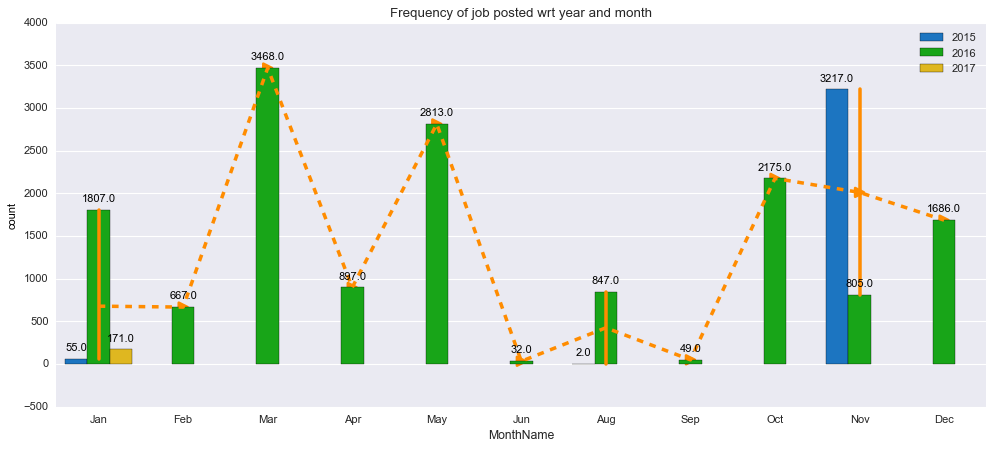

In [786]:
# showing graphically 
plt.figure(figsize=(15,6))
plt.style.use('seaborn')

ax = sns.barplot(x='MonthName',y='count',data=JobPostedDistribution.toPandas().head(15),hue='Year',palette='nipy_spectral')
sns.pointplot(x='MonthName',y='count',data=JobPostedDistribution.toPandas().head(15),markers='>',color='darkorange',linestyles='dashed',markersize=3,linewidth=5)

for p in ax.patches:
    ax.annotate(format(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),
               ha='center',va='center',xytext=(0,10),textcoords='offset points',color='black',fontsize=10)

plt.ylabel('count', fontsize = 10, color = 'black')
plt.xticks(rotation = 0);
plt.title("Frequency of job posted wrt year and month");
plt.legend(loc='upper right')
display()

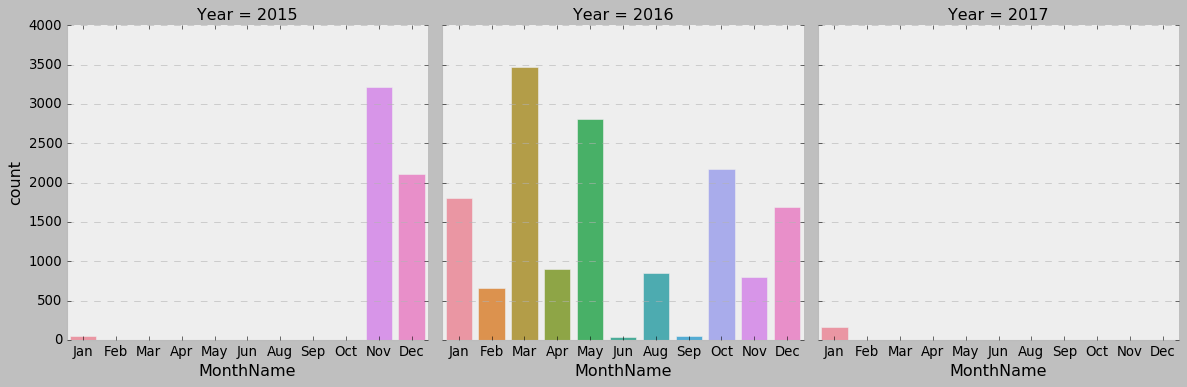

In [817]:
#JobPostedDistribution.toPandas().plot(x='MonthName',y='count',kind='bar')
plt.style.use('bmh')
sns.catplot(data=JobPostedDistribution.toPandas(),x='MonthName',y='count',kind='bar',col='Year')
plt.ylim((0,4000))
display()

In [787]:
#Q) which month has got highest number of job posted
FreqByMonth = jobTable.groupBy(month('date'),'monthName').count().orderBy('month(date)').select('monthName','count')
FreqByMonth = FreqByMonth.persist()
FreqByMonth.toPandas().head(11)

,monthName,count
0,Jan,2033
1,Feb,667
2,Mar,3468
3,Apr,897
4,May,2813
5,Jun,32
6,Aug,849
7,Sep,49
8,Oct,2175
9,Nov,4022


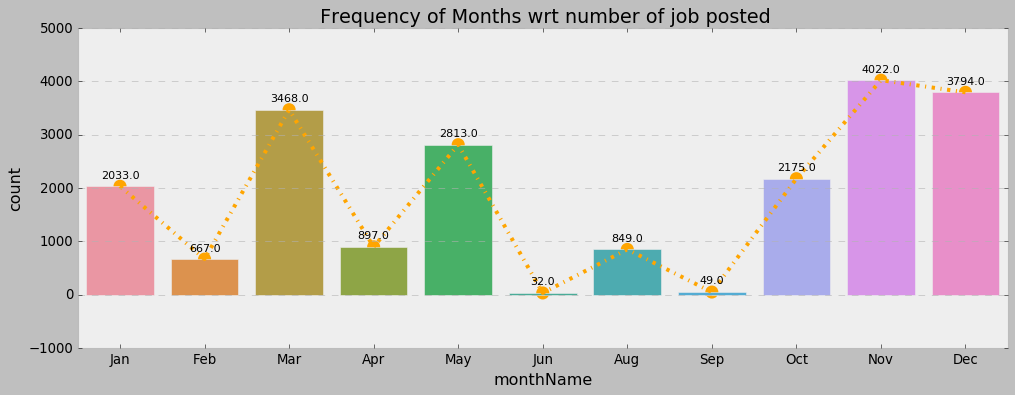

In [845]:
plt.figure(figsize=(15,5))
plt.style.use('bmh')
sns.pointplot(data=FreqByMonth.toPandas().head(11),x='monthName',y='count',marker='+',linestyles='dashdot',markersize=10,color='orange')
ax = sns.barplot(data=FreqByMonth.toPandas().head(11),x='monthName',y='count')

for p in ax.patches:
    ax.annotate(format(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),
               ha='center',va='center',xytext=(0,10),textcoords='offset points',color='black',fontsize=10)
plt.title(' Frequency of Months wrt number of job posted')
display()

In [795]:
# Q)Top 10 dates having max job posted.
Top10Dates = jobTable.groupBy('date','industry').count().orderBy(desc('count'))
Top10Dates.toPandas().head(10)

,date,industry,count
0,2016-01-29,IT-Software / Software Services,859
1,2015-12-29,IT-Software / Software Services,740
2,2015-11-22,IT-Software / Software Services,739
3,2015-11-23,IT-Software / Software Services,475
4,2016-03-29,IT-Software / Software Services,355
5,2016-10-07,IT-Software / Software Services,267
6,2016-03-31,IT-Software / Software Services,231
7,2016-01-29,Recruitment / Staffing,230
8,2016-03-30,IT-Software / Software Services,215
9,2016-08-16,Education / Teaching / Training,199


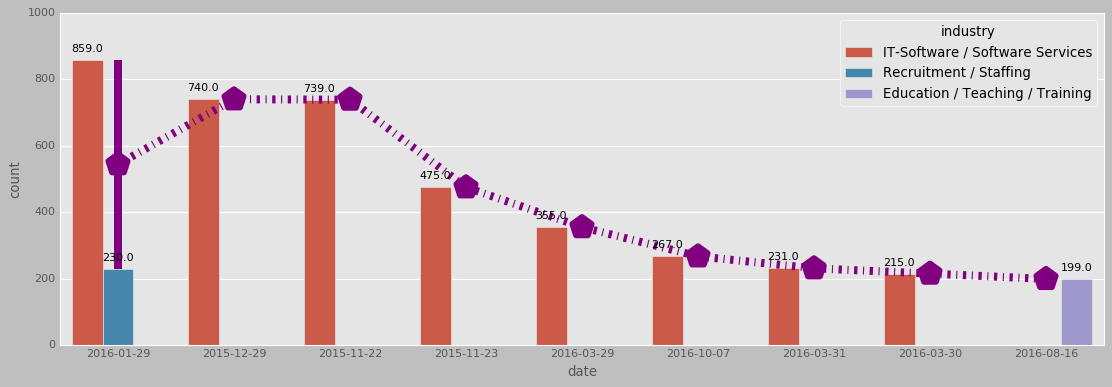

In [806]:
plt.figure(figsize=(15,5))
plt.style.use('ggplot')
sns.pointplot(data=Top10Dates.toPandas().head(10),x='date',y='count',color='purple',alpha=0.8,markers='p',linestyles='dashdot')
ax = sns.barplot(data=Top10Dates.toPandas().head(10),x='date',y='count',hue='industry')

for p in ax.patches:
    ax.annotate(format(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),
               ha='center',va='center',xytext=(0,10),textcoords='offset points',color='black',fontsize=10)

display()

In [818]:
# Q) Number of Job posted by quarter
FrequencyPerQuarter = jobTable.groupBy(quarter('date')).count().orderBy(desc('quarter(date)'),desc('count')).select(round('quarter(date)').alias('Quarter'),'count')

FrequencyPerQuarter.toPandas().head(4)

,Quarter,count
0,4,9991
1,3,898
2,2,3742
3,1,6168


<Figure size 400x240 with 0 Axes>

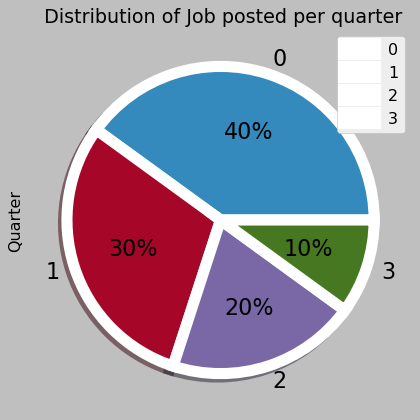

In [819]:
plt.figure(figsize=(5,3))
#ax = sns.barplot(data=FrequencyPerQuarter.toPandas().head(4),x='Quarter',y='count')

FrequencyPerQuarter.toPandas().plot.pie(autopct='%1.f%%',
                                                             wedgeprops={'linewidth':10,'edgecolor':'white'},
                                                             shadow=True,y='Quarter',
                                                             fontsize=20)
plt.title(" Distribution of Job posted per quarter")

display()

In [820]:
# Q) Number of Job posted by weeks
FreqPerWeek = jobTable.groupBy(weekofyear('date')).count().orderBy(desc('weekofyear(date)'),desc('count')).select(round('weekofyear(date)').alias('weekOfYear'),'count')
FreqPerWeek = FreqPerWeek.persist()
FreqPerWeek.toPandas().head(10)

,weekOfYear,count
0,53,1868
1,52,178
2,51,1019
3,50,36
4,49,928
5,48,1833
6,47,1482
7,46,3
8,45,136
9,44,375


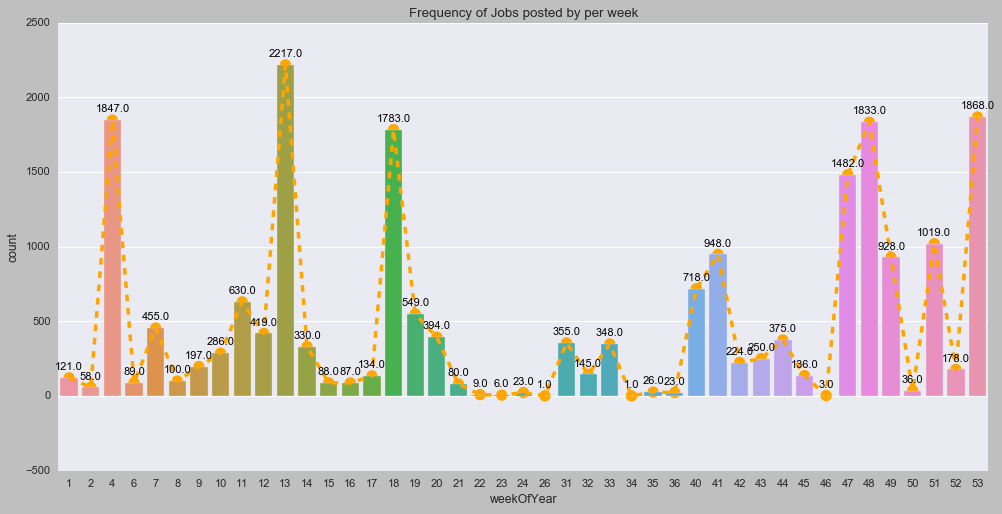

In [831]:
# Showing Visually
plt.figure(figsize=(15,7))
plt.style.use('seaborn')
sns.pointplot(data=FreqPerWeek.toPandas().head(50),x='weekOfYear',y='count',marker='+',linestyles='dashed',markersize=10,color='orange')
ax = sns.barplot(data=FreqPerWeek.toPandas().head(50),x='weekOfYear',y='count')

for p in ax.patches:
    ax.annotate(format(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),
               ha='center',va='center',xytext=(0,10),textcoords='offset points',color='black',fontsize=10)

plt.title('Frequency of Jobs posted by per week')

display()

In [853]:
# Skills vs Avg Pay wrt Top 5 Industries
skill = jobTable.filter((jobTable['skills']=='IT Software - Application Programming') | (jobTable['skills']=='Sales') | (jobTable['skills']=='ITES') | (jobTable['skills']=='Teaching') | (jobTable['skills']=='HR') | (jobTable['skills']=='Accounts'))

skillAvgPay = skill.filter((jobTable['jobLocation']=='Bangalore') | (jobTable['jobLocation']=='NCR') | (jobTable['jobLocation']=='Mumbai') | (jobTable['jobLocation']=='Hyderabad') | (jobTable['jobLocation']=='Chennai'))

skillAvgExpTitle = skill.filter((jobTable['jobTitle']=='Business Development Manager') | (jobTable['jobTitle']=='Project Manager') | (jobTable['jobTitle']=='Sales Executive') | (jobTable['jobTitle']=='Software Engineer') | (jobTable['jobTitle']=='Business Analyst') |  (jobTable['jobTitle']=='Business Development Executive'))

skillAvgExpIndus = skill.filter((jobTable['industry']=='IT-Software / Software Services') | (jobTable['industry']=='Education / Teaching / Training') | (jobTable['industry']=='Banking / Financial Services / Broking') | (jobTable['industry']=='BPO / Call Centre / ITES') | (jobTable['industry']=='Recruitment / Staffing') | (jobTable['industry']=='Medical / Healthcare / Hospitals'))

c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


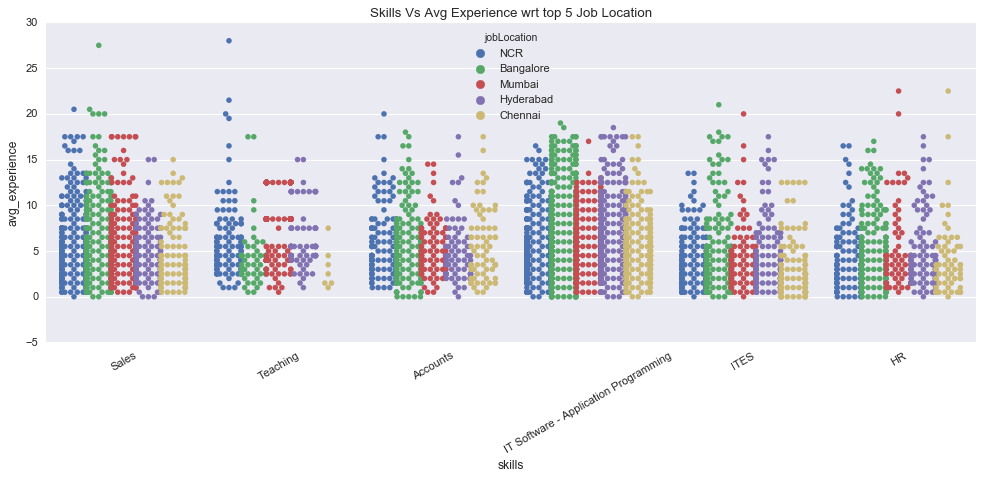

In [893]:
# Skills Vs Avg Experience wrt top 5 Job Location
plt.figure(figsize=(15,5))
plt.style.use('seaborn')
x = sns.swarmplot(data=skillAvgPay.toPandas(),x='skills',y='avg_experience',hue='jobLocation',dodge=True)
plt.xticks(rotation=30)
plt.title('Skills Vs Avg Experience wrt top 5 Job Location')
display()

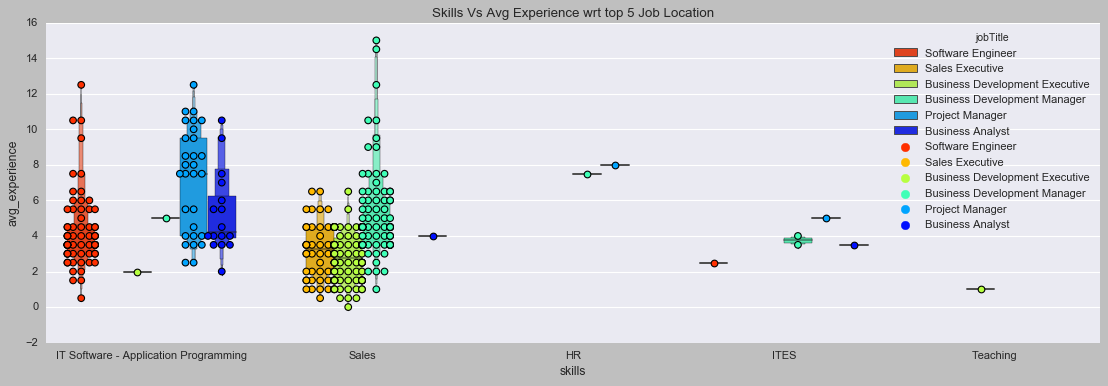

In [892]:
# Skills Vs Avg Experience wrt top 5 Job Location
plt.figure(figsize=(17,5))
plt.style.use('seaborn')
sns.boxenplot(data=skillAvgExpTitle.toPandas(),x='skills',y='avg_experience',hue='jobTitle',palette='jet_r')
ax = sns.swarmplot(data=skillAvgExpTitle.toPandas(),x='skills',y='avg_experience',hue='jobTitle',dodge=True,linewidth=1,size=6,edgecolor='black',palette='jet_r')
#ax.get_legend().remove()
plt.title('Skills Vs Avg Experience wrt top 5 Job Location')
display()

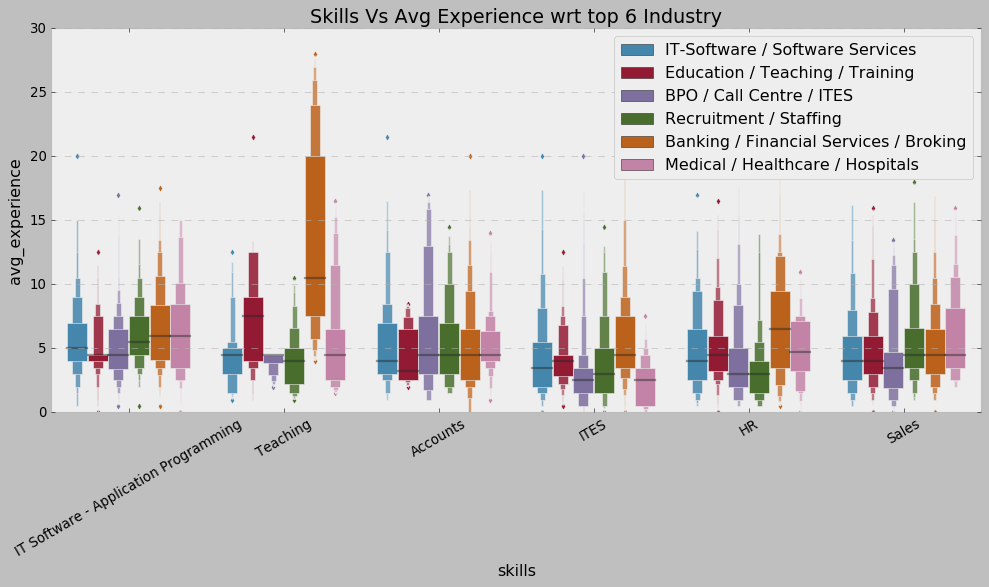

In [905]:
# Skills Vs Avg Experience wrt top 6 Industry
plt.figure(figsize=(15,6))
plt.style.use('bmh')
sns.boxenplot(data=skillAvgExpIndus.toPandas(),x='skills',y='avg_experience',hue='industry',dodge=True,linewidth=1)
plt.xticks(rotation='30')
plt.ylim((0,30))
plt.title('Skills Vs Avg Experience wrt top 6 Industry')
plt.legend(loc='upper right')
display()

In [906]:
#Q))Avg experience wrt skills wrt top 5 JobTitle
Top10AvgExp=jobTable.groupBy('industry','skills').agg({'avg_experience':'avg'}).select('industry','skills',round('avg(avg_experience)').alias('totalAvgExperience')).orderBy(desc('totalAvgExperience'))
Top10AvgExp = Top10AvgExp.persist()
Top10AvgExp.toPandas().head(10)

,industry,skills,totalAvgExperience
0,NGO / Social Services / Regulators / Industry ...,Top Management,25.0
1,Automobile / Auto Anciliary / Auto Components,Top Management,23.0
2,Oil and Gas / Energy / Power / Infrastructure,Top Management,21.0
3,Fertilizers / Pesticides,Sales,20.0
4,Agriculture / Dairy,Top Management,19.0
5,Architecture / Interior Design,Production,18.0
6,Travel / Hotels / Restaurants / Airlines / Rai...,Site Engineering,18.0
7,Courier / Transportation / Freight / Warehousing,Top Management,18.0
8,Education / Teaching / Training,Site Engineering,18.0
9,Medical Devices / Equipments,IT Software - Application Programming,18.0


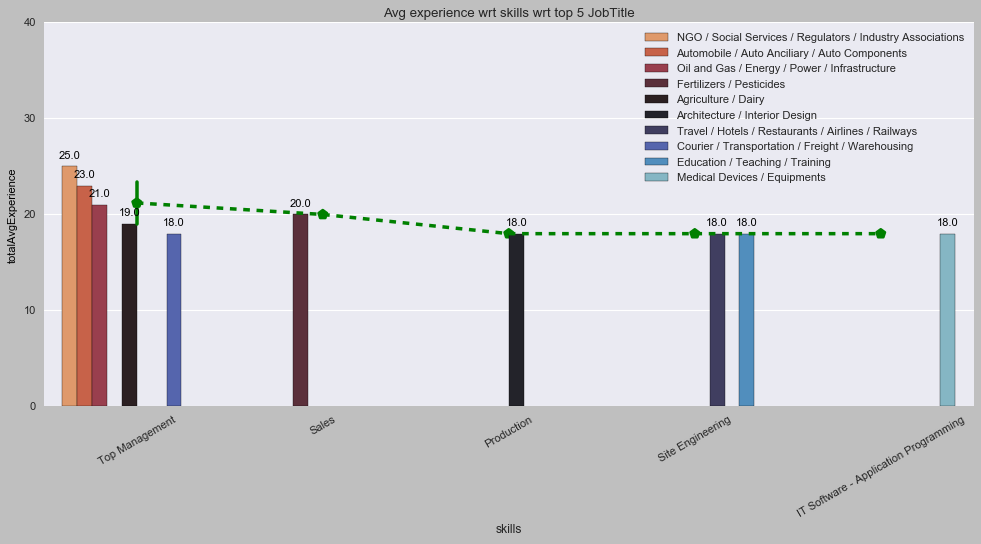

In [946]:
# showing graphically 
plt.figure(figsize=(15,6))
plt.style.use('seaborn')

ax = sns.barplot(x='skills',y='totalAvgExperience',data=Top10AvgExp.toPandas().head(10),hue='industry',palette='icefire_r')
sns.pointplot(x='skills',y='totalAvgExperience',data=Top10AvgExp.toPandas().head(10),markers='p',color='green',linestyles='--',markersize=3,linewidth=5)

for p in ax.patches:
    ax.annotate(format(p.get_height()),(p.get_x()+p.get_width()/2,p.get_height()),
               ha='center',va='center',xytext=(0,10),textcoords='offset points',color='black',fontsize=10)

plt.ylabel('totalAvgExperience', fontsize = 10, color = 'black')
plt.xticks(rotation = 30);
plt.yticks((0,10,20,30,40))
plt.title("Avg experience wrt skills wrt top 5 JobTitle");
plt.legend(loc='upper right')
display()

In [1001]:
AvgExpAvgPay = jobTable.select('industry','skills','jobLocation','avg_experience','avg_pay')

In [1002]:
AvgExpAvgPay.agg(F.skewness("avg_experience"),F.skewness("avg_pay")).show()

+------------------------+-----------------+
|skewness(avg_experience)|skewness(avg_pay)|
+------------------------+-----------------+
|      1.3646242559753716|5.527440439407636|
+------------------------+-----------------+



In [1003]:
AvgExpAvgPay.agg(F.corr("avg_experience","avg_pay")).show()

+-----------------------------+
|corr(avg_experience, avg_pay)|
+-----------------------------+
|          0.19086220066094262|
+-----------------------------+



In [1004]:
# need to Standardize the columns as skewness is high and weak correlation between AvgExp and AvgPay
AvgExpAvgPay = AvgExpAvgPay.withColumn('avg_experience',F.sqrt(AvgExpAvgPay['avg_experience']))
AvgExpAvgPay = AvgExpAvgPay.withColumn('avg_pay',F.cbrt(F.cbrt(F.cbrt(F.cbrt(AvgExpAvgPay['avg_pay'])))))

In [1005]:
AvgExpAvgPay.agg(F.skewness("avg_experience"),F.skewness("avg_pay")).show()

+------------------------+------------------+
|skewness(avg_experience)| skewness(avg_pay)|
+------------------------+------------------+
|     0.23897124142827764|1.4399842142535513|
+------------------------+------------------+



In [1006]:
AvgExpAvgPay = AvgExpAvgPay.filter(AvgExpAvgPay['avg_pay']!=1.0)

In [1007]:
AvgExpAvgPay.agg(F.corr("avg_experience","avg_pay")).show()

+-----------------------------+
|corr(avg_experience, avg_pay)|
+-----------------------------+
|           0.7254784504484884|
+-----------------------------+



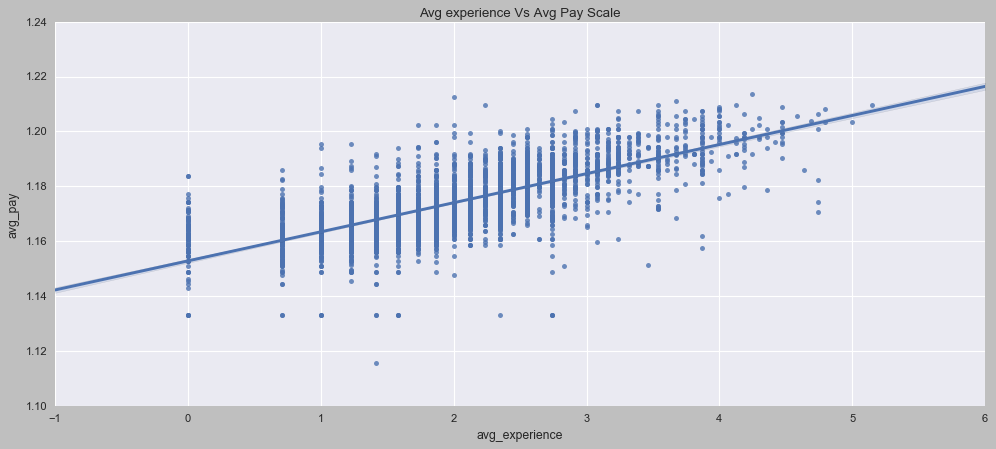

In [1025]:
# standardize it and perform scatterplot wrt industry,location,skills
plt.figure(figsize=(15,6))
plt.style.use('seaborn')
x= sns.regplot(data=AvgExpAvgPay.toPandas(),x='avg_experience',y='avg_pay')
plt.title("Avg experience Vs Avg Pay Scale");
display()

In [1029]:
# Calculating Avg experience Vs Avg Pay Scale wrt Top 6 industry
AvgExpAvgPay = AvgExpAvgPay.filter((AvgExpAvgPay['industry']=='IT-Software / Software Services') | (AvgExpAvgPay['industry']=='Education / Teaching / Training') | (AvgExpAvgPay['industry']=='Banking / Financial Services / Broking') | (AvgExpAvgPay['industry']=='BPO / Call Centre / ITES') | (AvgExpAvgPay['industry']=='Recruitment / Staffing') | (AvgExpAvgPay['industry']=='Medical / Healthcare / Hospitals'))

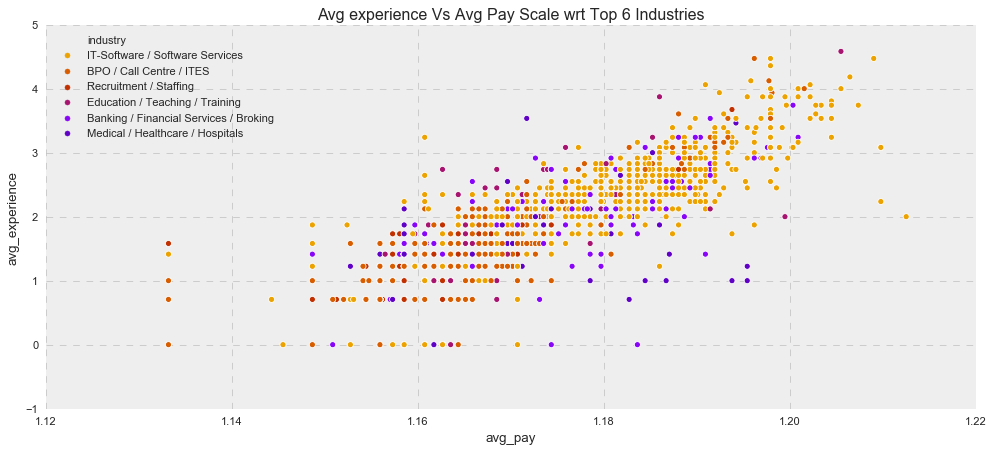

In [1055]:
# standardize it and perform scatterplot of Avg experience Vs Avg Pay Scale wrt Top 6 industry
plt.figure(figsize=(15,6))
plt.style.use('bmh')
x= sns.scatterplot(data=AvgExpAvgPay.toPandas(),x='avg_pay',y='avg_experience',hue='industry',palette='gnuplot_r',s=30)
plt.title("Avg experience Vs Avg Pay Scale wrt Top 6 Industries");
plt.legend(loc='best')
display()

In [1056]:
# Calculating Avg experience Vs Avg Pay Scale wrt Top 5 location
AvgExpAvgPay = AvgExpAvgPay.filter((AvgExpAvgPay['jobLocation']=='Bangalore') | (AvgExpAvgPay['jobLocation']=='NCR') | (AvgExpAvgPay['jobLocation']=='Mumbai') | (AvgExpAvgPay['jobLocation']=='Hyderabad') | (AvgExpAvgPay['jobLocation']=='Chennai'))

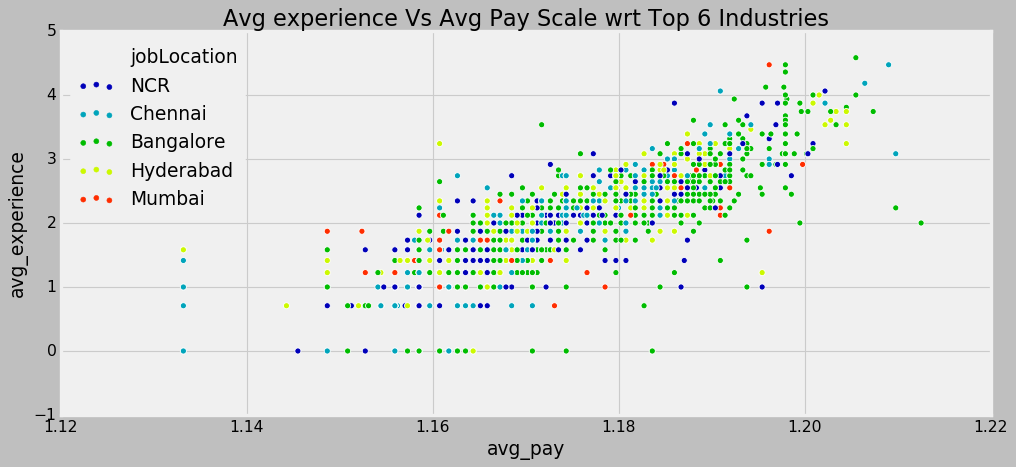

In [1069]:
# standardize it and perform scatterplot of Avg experience Vs Avg Pay Scale wrt Top 5 Job Location
plt.figure(figsize=(15,6))
plt.style.use('fivethirtyeight')
x= sns.scatterplot(data=AvgExpAvgPay.toPandas(),x='avg_pay',y='avg_experience',hue='jobLocation',palette='nipy_spectral',s=30)
plt.title("Avg experience Vs Avg Pay Scale wrt Top 5 Job Location");
plt.legend(loc='best')
display()

In [1070]:
#Calculating Avg experience Vs Avg Pay Scale wrt Top 6 Skills
AvgExpAvgPay = AvgExpAvgPay.filter((AvgExpAvgPay['skills']=='IT Software - Application Programming') | (AvgExpAvgPay['skills']=='Sales') | (AvgExpAvgPay['skills']=='ITES') | (AvgExpAvgPay['skills']=='Teaching') | (AvgExpAvgPay['skills']=='HR') | (AvgExpAvgPay['skills']=='Accounts'))

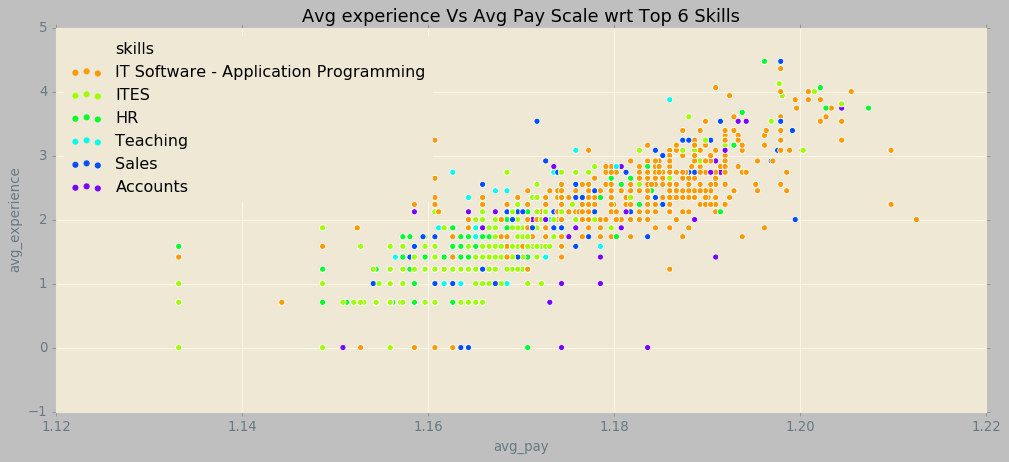

In [1085]:
# standardize it and perform scatterplot of Avg experience Vs Avg Pay Scale wrt Top 6 Skills
plt.figure(figsize=(15,6))
plt.style.use('Solarize_Light2')
x= sns.scatterplot(data=AvgExpAvgPay.toPandas(),x='avg_pay',y='avg_experience',hue='skills',palette='gist_rainbow',s=30)
plt.title("Avg experience Vs Avg Pay Scale wrt Top 6 Skills");
plt.legend(loc='best')
display()

In [ ]:
#Q) Top 5 industry in each quarter who post maximum job portal
job2 = jobTable.groupBy(quarter('date'),'industry').count().select(round('quarter(date)').alias('Quarter').cast('integer'),'industry',round('count').alias('cnt'))

In [88]:
#Q) Top 5 industry in each quarter who post maximum job portal  (continue)

job2.registerTempTable('job2')

RankQuarter = spark.sql('select CAST(Quarter as integer), industry,cnt,rnk from (select Quarter, industry,cnt, dense_rank() over (partition by Quarter order by cnt desc) as rnk from job2) where rnk <= 5 order by 1, 3 desc')
RankQuarter.toPandas().head(30)

,Quarter,industry,cnt,rnk
0,1,IT-Software / Software Services,2939,1
1,1,Recruitment / Staffing,345,2
2,1,Banking / Financial Services / Broking,306,3
3,1,BPO / Call Centre / ITES,295,4
4,1,Internet / Ecommerce,228,5
5,2,IT-Software / Software Services,1109,1
6,2,Education / Teaching / Training,394,2
7,2,BPO / Call Centre / ITES,353,3
8,2,Banking / Financial Services / Broking,212,4
9,2,Internet / Ecommerce,165,5


In [89]:
# Showing Visually
plt.figure(figsize=(15,5))
sns.catplot(data=RankQuarter.toPandas().head(30),x='industry',y='cnt',hue='rnk',col='Quarter',kind='bar')
plt.xticks(rotation = 30);
plt.title('Top 5 industry in each quarter who post maximum job portal')
display()

In [90]:
#Q) Top 5 skills in each industry in each year
skills_set = jobTable.groupBy(year('date'),'industry','skills').count().select(round('year(date)').alias('Year').cast('integer'),'industry','skills',round('count').alias("total"))

In [91]:
#Q) Top 5 industry in each year wrt skills who post maximum job portal(continue)
skills_set.registerTempTable('skill_set')

RankSkillsQuarter = spark.sql('select Year, industry,skills,total,rnk from (select Year, industry,skills,total, dense_rank() over (partition by Year order by total desc) as rnk from skill_set) where rnk <= 5 order by 1, 4 desc')

RankSkillsQuarter.toPandas().head(30)

,Year,industry,skills,total,rnk
0,2015,IT-Software / Software Services,IT Software - Application Programming,1120,1
1,2015,IT-Software / Software Services,Sales,263,2
2,2015,BPO / Call Centre / ITES,ITES,171,3
3,2015,Education / Teaching / Training,Teaching,148,4
4,2015,IT-Software / Software Services,IT Software - eCommerce,125,5
5,2016,IT-Software / Software Services,IT Software - Application Programming,3293,1
6,2016,Education / Teaching / Training,Teaching,831,2
7,2016,BPO / Call Centre / ITES,ITES,690,3
8,2016,IT-Software / Software Services,Sales,350,4
9,2016,Banking / Financial Services / Broking,Sales,234,5


In [92]:
#Q) Top 5 avg paying job wrt skills and year
max_pay = jobTable.groupBy(year('date'),'skills').agg({'avg_pay':'sum'}).select(round('year(date)').alias('Year'),'skills',round('sum(avg_pay)').alias('avgPay').cast('long'))

In [93]:
max_pay.registerTempTable('maxPay')

spark.sql('select Year,skills,avgPay,rnk from (select Year,skills,avgPay,dense_rank() over (partition by Year order by avgPay desc) as rnk from maxPay) where rnk <= 5 order by 1, 3 desc').toPandas().head(30)

,Year,skills,avgPay,rnk
0,2015,IT Software - Application Programming,32901230,1
1,2015,Sales,24483312,2
2,2015,Top Management,10750018,3
3,2015,ITES,9995291,4
4,2015,Accounts,9157672,5
5,2016,IT Software - Application Programming,193533947,1
6,2016,Sales,143916546,2
7,2016,ITES,72048333,3
8,2016,Accounts,58653045,4
9,2016,HR,37235604,5


In [94]:
#Q) Top 5 companies which has highest avg pay wrt experience,skills and year
topComapnies = jobTable.groupBy(year('date'),'company','skills','avg_experience').agg({'avg_pay':'sum'}).select(round('year(date)').alias('Year'),'company','skills','avg_experience',round('sum(avg_pay)').alias('avgPay').cast('long'))

In [95]:
topComapnies.registerTempTable('topCompanies')

spark.sql('select Year,company,skills,avg_experience,avgPay,rnk from (select  Year,company,skills,avg_experience,avgPay,dense_rank() over (partition by Year order by avgPay desc) as rnk from topCompanies) where rnk <= 5 order by 1 desc, 6').toPandas().head(15)

,Year,company,skills,avg_experience,avgPay,rnk
0,2017,ABC Consultants Pvt Ltd,Sales,3.0,1125001,1
1,2017,The Catalyst hiring for Multinational Manufact...,Accounts,8.5,1125001,1
2,2017,qualibrisk hiring for A Product Company,IT Software - Application Programming,15.0,1000001,2
3,2017,om consultancy hiring for A Leading MNC intern...,ITES,3.5,625004,3
4,2017,Achievers Spot,Medical,0.0,600003,4
5,2017,Rian Placements hiring for NBFC client,Accounts,6.5,500001,5
6,2016,YOGAM BPO,ITES,0.5,5000025,1
7,2016,ViXi IT Solutions hiring for IBM India Private...,IT Software - Application Programming,15.0,3250001,2
8,2016,Axis Jobs,Production,10.0,3200004,3
9,2016,Premium-Jobs hiring for Startup,Accounts,15.0,2750001,4


In [96]:
jobTable.groupBy('skills','jobtitle').count().orderBy(desc('count')).toPandas().head(10)

,skills,jobtitle,count
0,Sales,Business Development Executive,82
1,Sales,Business Development Manager,78
2,IT Software - Application Programming,Software Engineer,68
3,Journalism,Content Writer,52
4,Sales,Sales Executive,50
5,IT Software - Application Programming,PHP Developer,50
6,IT Software - Application Programming,Senior Software Engineer,48
7,ITES,Medical Coding Transcription - We Will Help Yo...,47
8,IT Software - Application Programming,Java Developer,47
9,IT Software - Application Programming,Android Developer,47


In [97]:
#Q) Top 5 jobTitles offered wrt industry and skill

topJobTitle = jobTable.groupBy(year('date'),'industry','skills','jobTitle').count().select(round('year(date)').alias('Year'),'industry','skills','jobTitle',round('count').alias('total'))

In [98]:
topJobTitle.registerTempTable('topJobTitle')

spark.sql('select skills,jobTitle,total,rnk from (select  skills,jobTitle,total,total,dense_rank() over (partition by skills,jobTitle order by total desc) as rnk from topJobTitle) where rnk <= 5 order by 3 desc').toPandas().head(30)

,skills,jobTitle,total,rnk
0,ITES,Medical Coding Transcription - We Will Help Yo...,44,1
1,IT Software - Application Programming,Software Engineer,31,1
2,IT Software - Application Programming,Senior Software Engineer,31,1
3,Sales,Business Development Executive,27,1
4,Sales,Business Development Executive,27,1
5,IT Software - Application Programming,PHP Developer,27,1
6,IT Software - Application Programming,Java Developer,26,1
7,IT Software - Application Programming,Android Developer,25,1
8,Journalism,Content Writer,22,1
9,IT Software - Application Programming,Software Engineer,18,2


In [99]:
# Top 10 Job Titles Posted till now
spark.sql("select distinct jobTitle,count(*) as total from topJobTitle group by jobTitle order by total desc").toPandas().head(10)

,jobTitle,total
0,Business Development Manager,40
1,Project Manager,33
2,Business Development Executive,31
3,Sales Executive,30
4,Marketing Executive,28
5,Software Engineer,24
6,Business Analyst,23
7,Graphic Designer,21
8,Sales Manager,21
9,Content Writer,19
